# Plot results of BP mitigation methods

Before you run this notebook, check the Save folder.

If the save folder is empty, you need to run the notebooks `TrainEpoch.ipynb`, then `capacity-ed.ipynb`

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer, IBMQ
from qiskit.utils import QuantumInstance
from qiskit.utils import algorithm_globals
from qiskit.algorithms.optimizers import COBYLA, NELDER_MEAD, SLSQP, SPSA
from qiskit.opflow import Z, X, I, StateFn, PauliExpectation, Gradient
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN, OpflowQNN
from qiskit_machine_learning.neural_networks import EffectiveDimension
from qiskit_machine_learning.algorithms.classifiers import VQC, NeuralNetworkClassifier
from qiskit.quantum_info import SparsePauliOp

from Components.circuits import preTrainedBlockGenerator, layerwise_training, featureMapGenerator, AnsatzGenerator
from Components.data import iris
from Components.utils import plot_loss, score, parity, classification_callback, plot_objfn_range, result_to_objfun_dataframes, save_results, smooth, plot_score_range
from Components.train import create_qnn, sampling_experiment

from qiskit.providers.fake_provider import FakeVigo, FakePerth

import pandas as pd

import time

from IPython.display import clear_output

%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

# Retrieve data

In [2]:
SAVE_PATH = './Saves-iris-v3'

LossFunctions = [pd.read_csv(f'{SAVE_PATH}/LossFunction/m{i}.csv', index_col=[0]) for i in range(4)]

Weights_0 = pd.read_csv(f'{SAVE_PATH}/Weights/m0/sample_0.csv', index_col=[0])
Weights_1 = pd.read_csv(f'{SAVE_PATH}/Weights/m1/sample_0.csv', index_col=[0])
Weights_2 = pd.read_csv(f'{SAVE_PATH}/Weights/m2/sample_0.csv', index_col=[0])
Weights_3 = pd.read_csv(f'{SAVE_PATH}/Weights/m3/sample_0.csv', index_col=[0])

d = [w.shape[1] for w in [Weights_0, Weights_1, Weights_2, Weights_3]]

Local_eff_0 = [pd.read_csv(f'{SAVE_PATH}/LocalED/m0/sample_{i}.csv', index_col=[0]) for i in range(10)]
Local_eff_1 = [pd.read_csv(f'{SAVE_PATH}/LocalED/m1/sample_{i}.csv', index_col=[0]) for i in range(10)]
Local_eff_2 = [pd.read_csv(f'{SAVE_PATH}/LocalED/m2/sample_{i}.csv', index_col=[0]) for i in range(10)]
Local_eff_3 = [pd.read_csv(f'{SAVE_PATH}/LocalED/m3/sample_{i}.csv', index_col=[0]) for i in range(10)]

Global_eff_0 = pd.read_csv(f'{SAVE_PATH}/GlobalED/m0/sample.csv', index_col=[0])
Global_eff_1 = pd.read_csv(f'{SAVE_PATH}/GlobalED/m1/sample.csv', index_col=[0])
Global_eff_2 = pd.read_csv(f'{SAVE_PATH}/GlobalED/m2/sample.csv', index_col=[0])
Global_eff_3 = pd.read_csv(f'{SAVE_PATH}/GlobalED/m3/sample.csv', index_col=[0])

test_scores = [pd.read_csv(f'{SAVE_PATH}/Scores/Test/m{i}.csv', index_col=[0]) for i in range(4)]
train_score = [pd.read_csv(f'{SAVE_PATH}/Scores/Train/m{i}.csv', index_col=[0]) for i in range(4)]

MAX_ITER = 150 # LossFunctions[0].iloc[0].shape[0]
ITER_STEP_SIZE = 25
n = [75, 90, 105, 120, 135, 150, 200, 300, 400, 1000, 5000, 8000, 10000, 40000, 60000, 100000, 150000, 200000, 500000, 1000000]

# Plot Objective Function value range for different instances and methods

[]

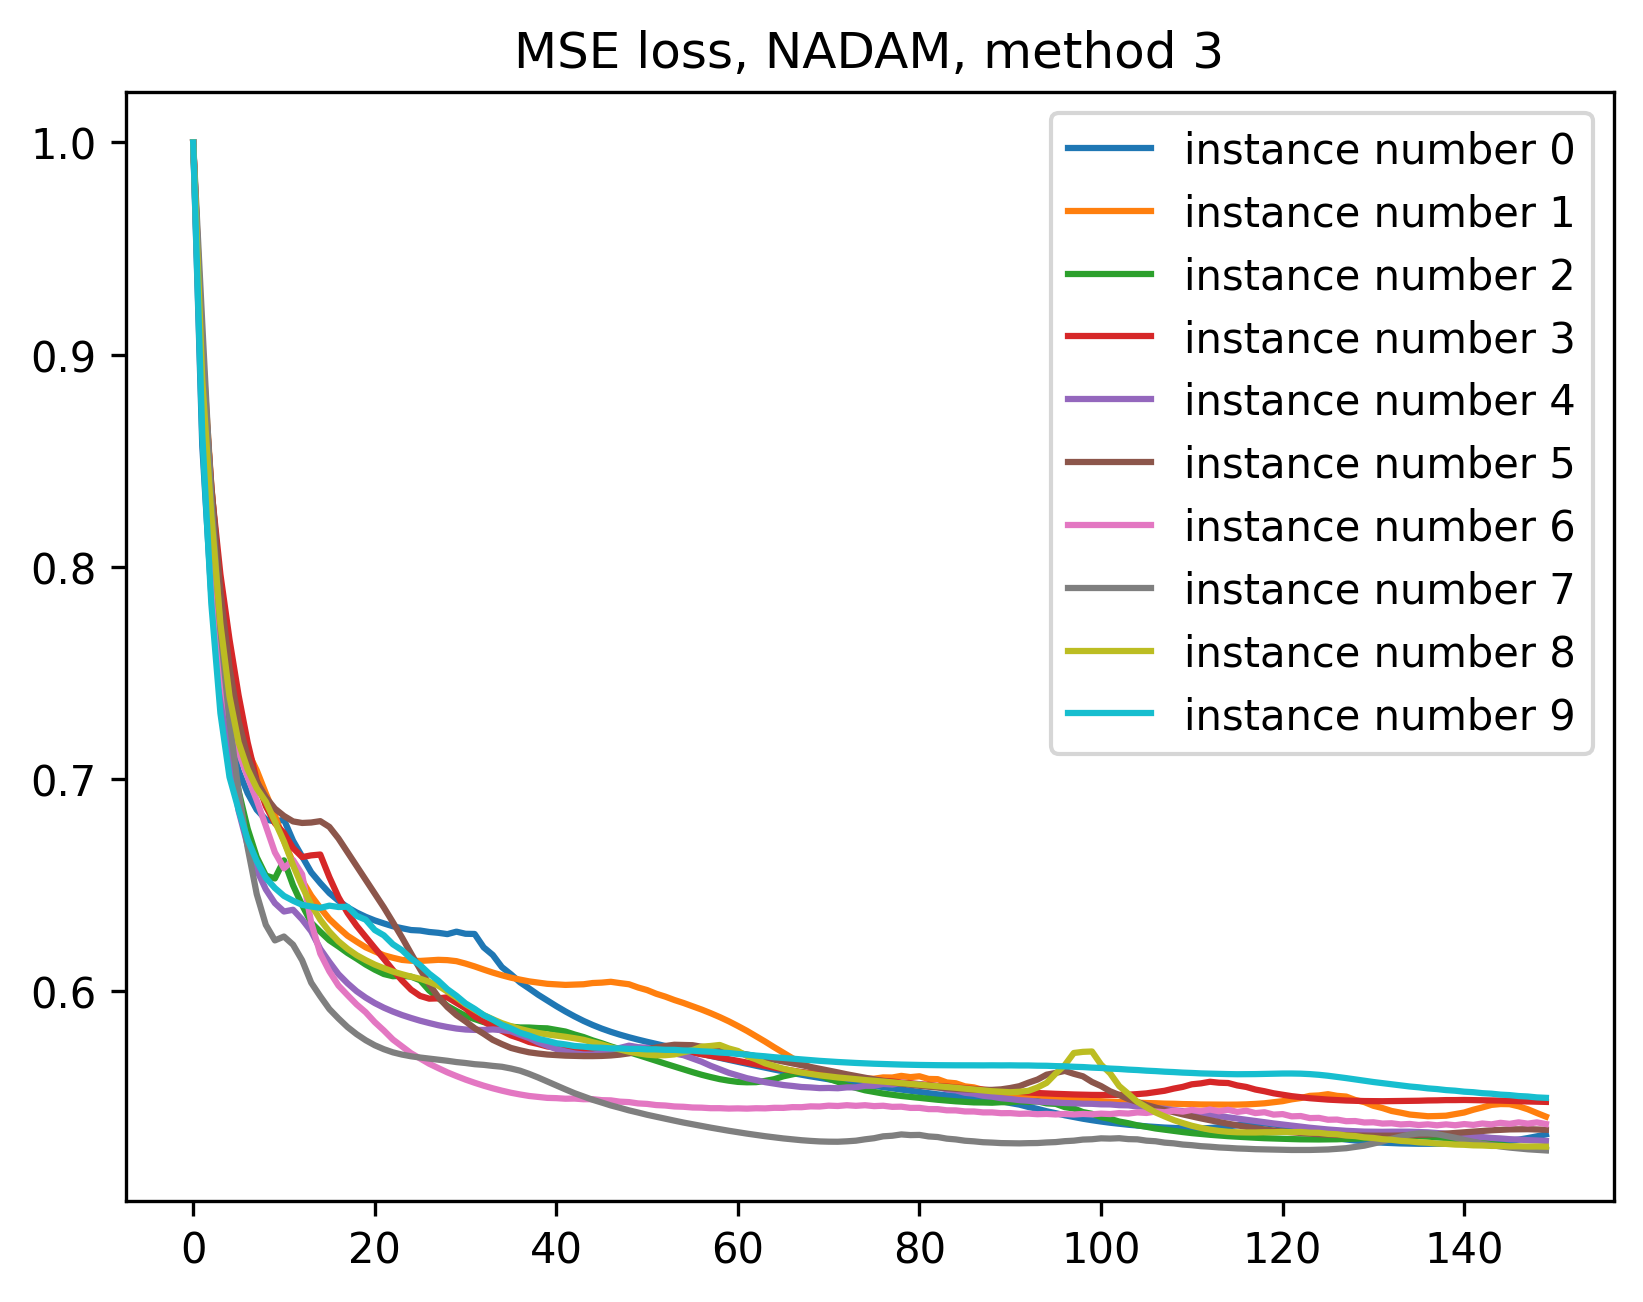

In [3]:
l_f = LossFunctions[3]

for i in range(len(l_f)):
    plt.plot(range(len(l_f.iloc[i])), l_f.iloc[i], label=f'instance number {i}')

plt.title('MSE loss, NADAM, method 3')
plt.legend(loc='best')
plt.plot()

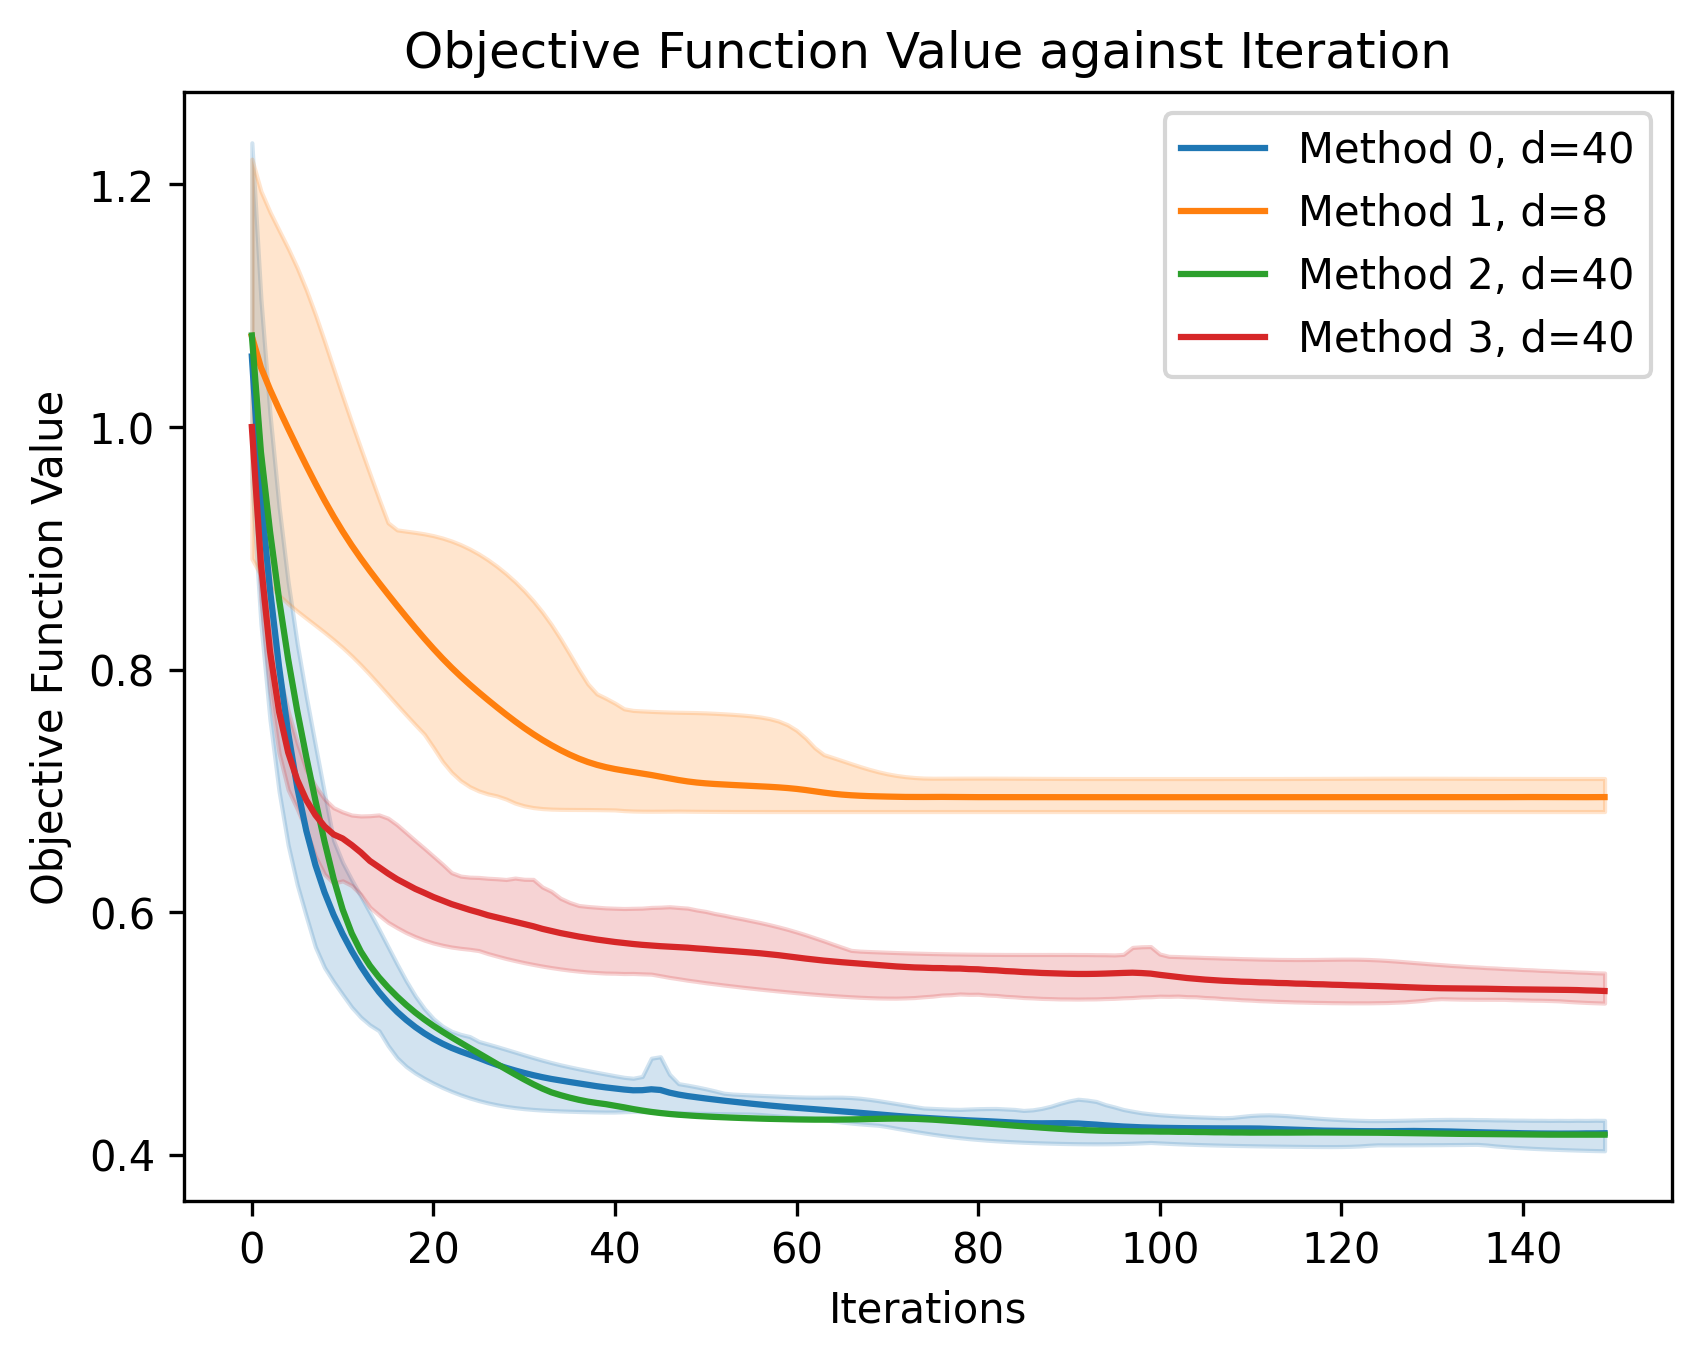

In [4]:
plot_objfn_range(LossFunctions, smooth_weight=0, d=d)

# Animate effective dimension values for the method's instances over the training period

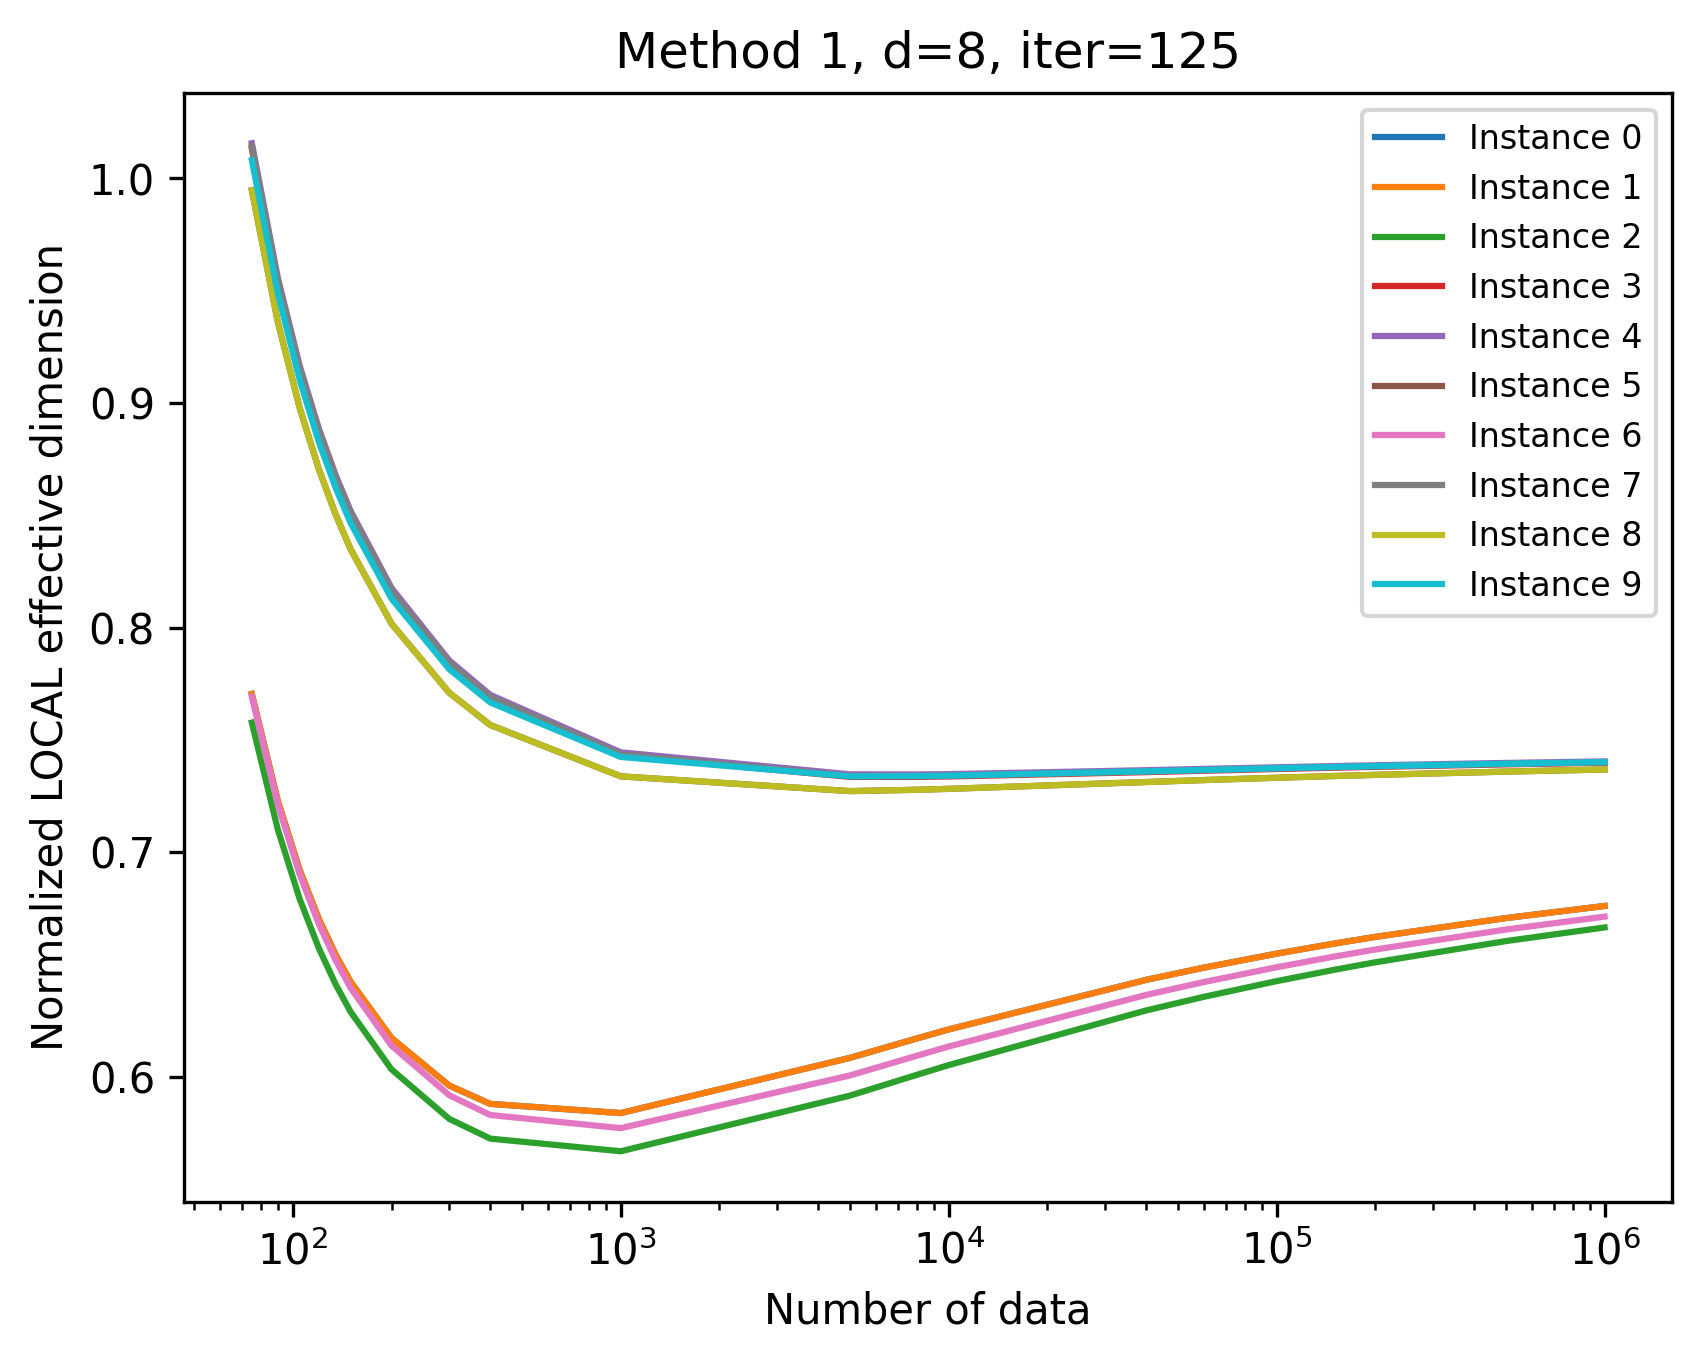

In [5]:
import time
from IPython.display import clear_output

m_no = 1  # Method no
l_ed = Local_eff_0 if m_no==0 else Local_eff_1 if m_no==1 else Local_eff_2 if m_no==2 else Local_eff_3
w_ed = Weights_0 if m_no==0 else Weights_1 if m_no==1 else Weights_2 if m_no==2 else Weights_3

max_iter = len(Local_eff_0[0])
for s_iter in range(max_iter):
    for i in range(len(l_ed)):
        plt.plot(n, np.array(l_ed[i].iloc[s_iter]) / w_ed.shape[1], label=f"Instance {i}")

    clear_output(wait=True)
    plt.xlabel("Number of data")
    plt.ylabel(f"Normalized LOCAL effective dimension")
    plt.title(f'Method {m_no}, d={w_ed.shape[1]}, iter={s_iter*ITER_STEP_SIZE}')
    plt.legend(prop={'size': 8})
    plt.plot()
    plt.semilogx()
    plt.show()
    time.sleep(1)

# Plot Local Effective Dimension for the selected instance of each method

[]

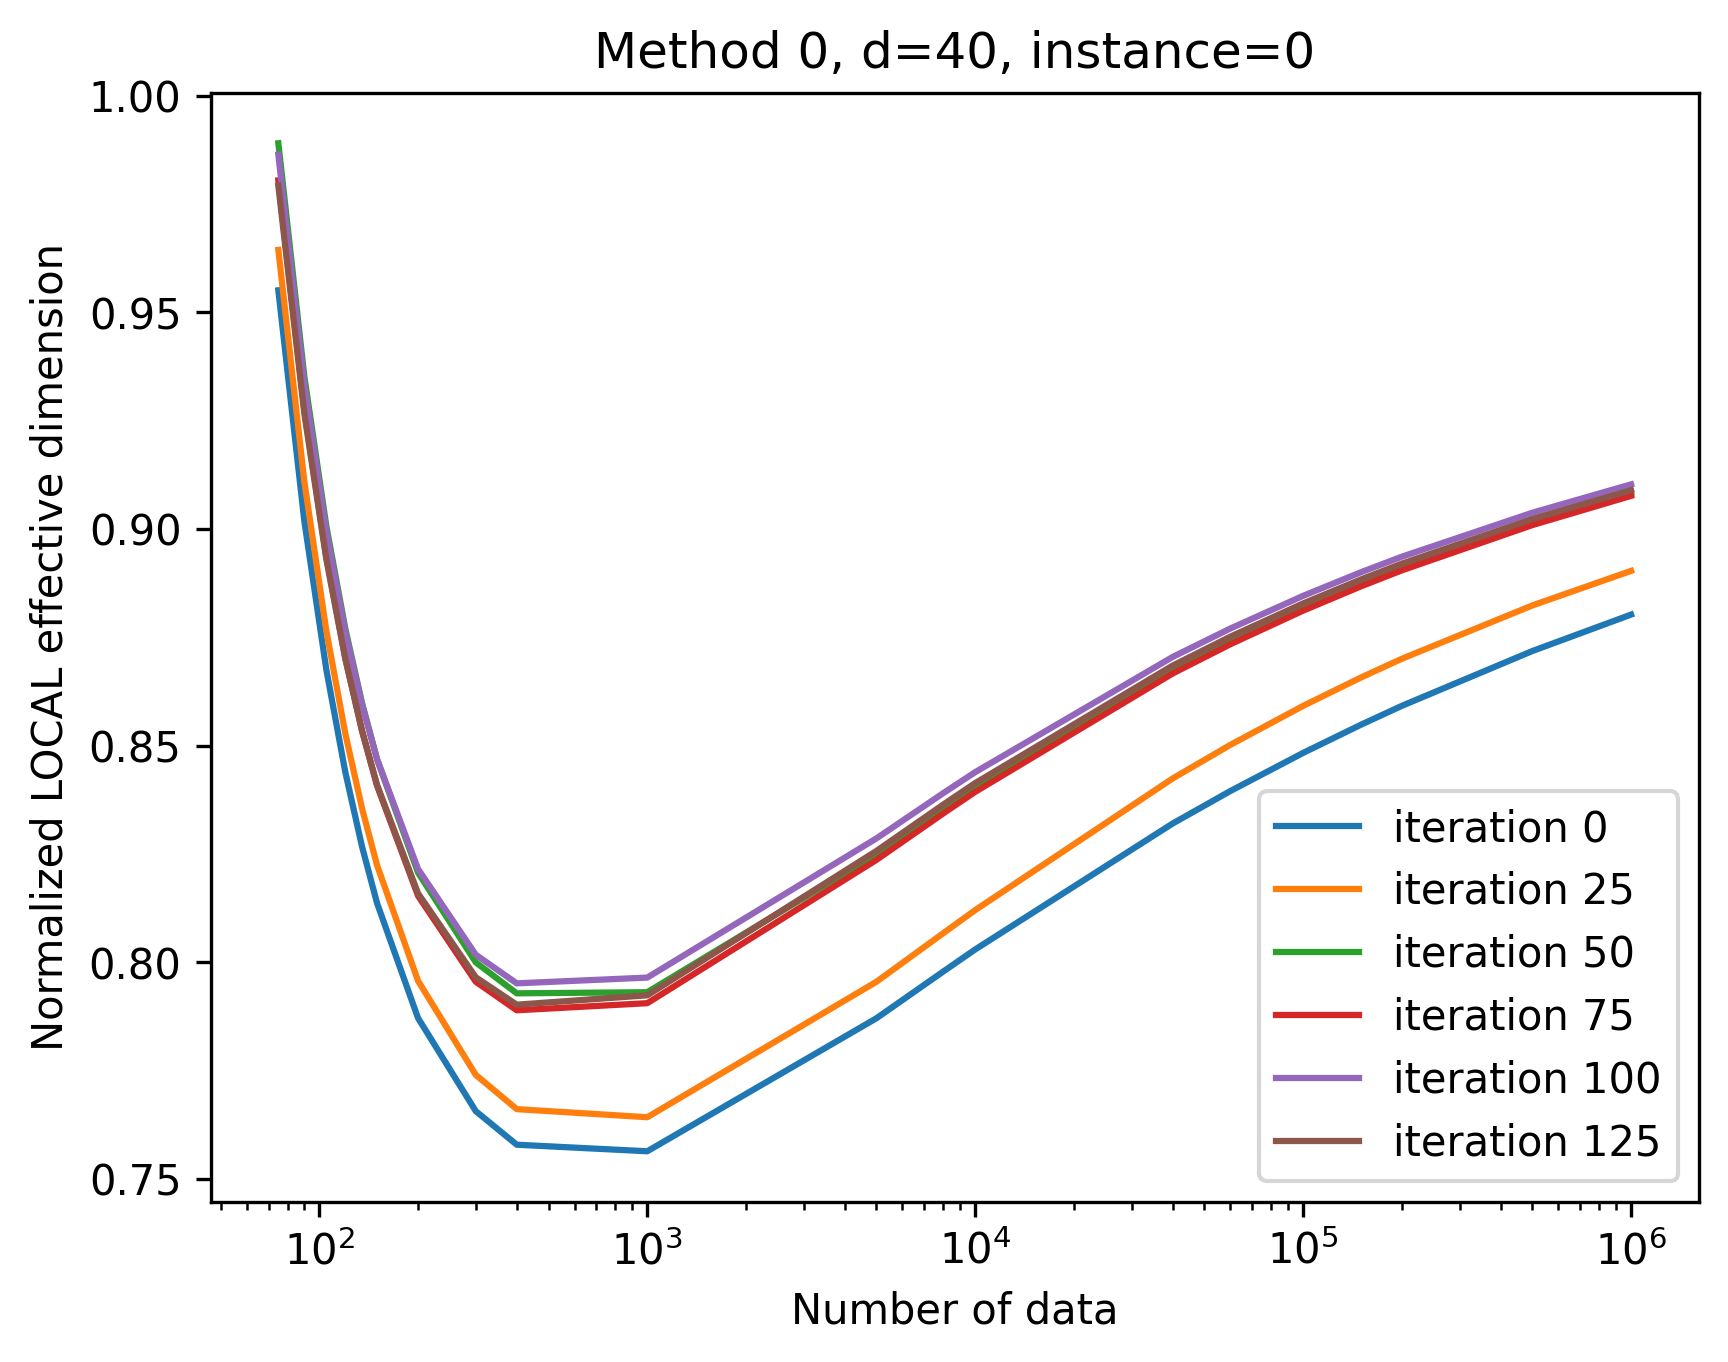

In [6]:
sel_instance = 0
for i in range(len(Local_eff_0[0])):
    plt.plot(n, np.array(Local_eff_0[sel_instance].iloc[i]) / Weights_0.shape[1], label=f"iteration {i*ITER_STEP_SIZE}")

plt.xlabel("Number of data")
plt.ylabel(f"Normalized LOCAL effective dimension")
plt.title(f'Method 0, d={Weights_0.shape[1]}, instance={sel_instance}')
plt.legend()
plt.plot()
plt.semilogx()

[]

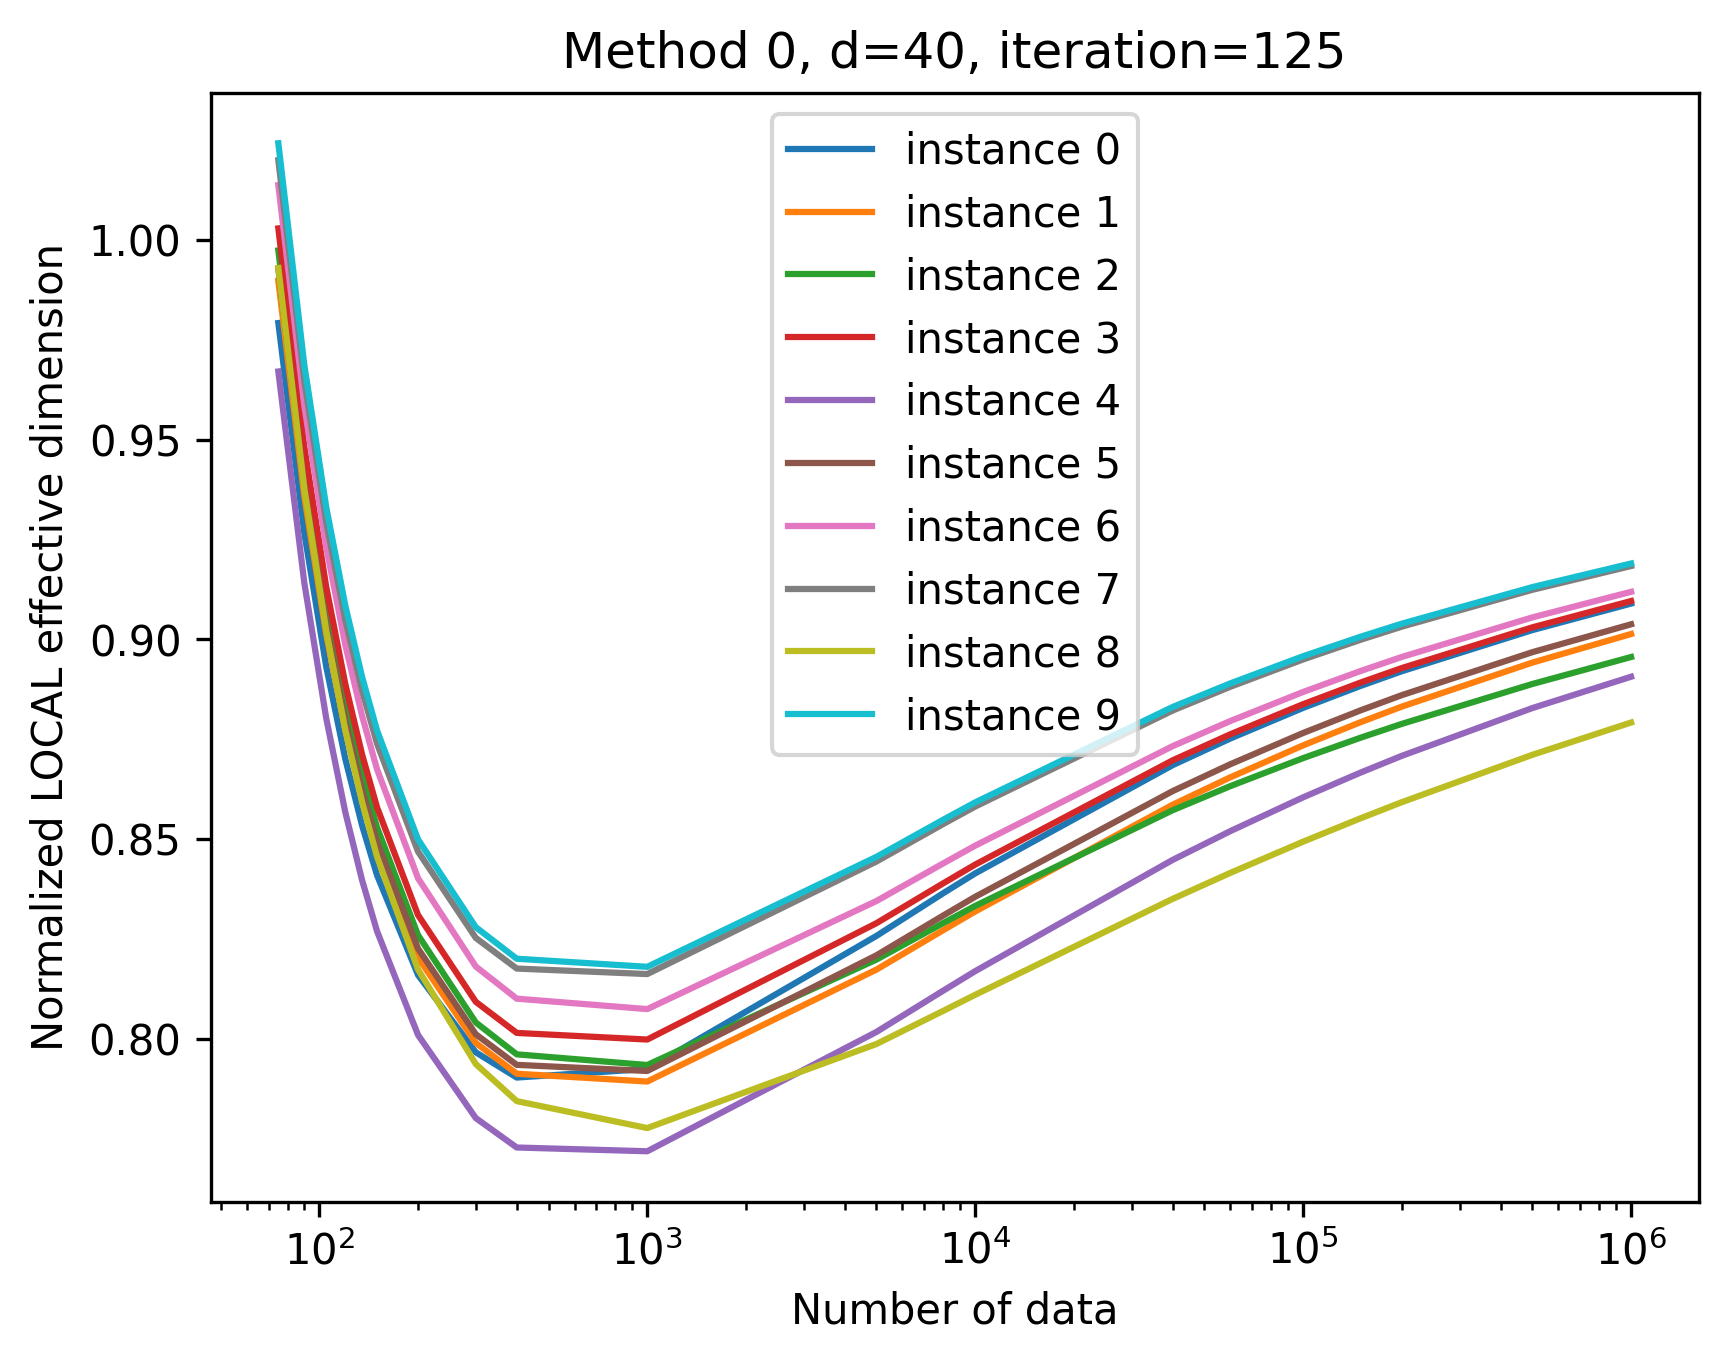

In [7]:
### Plot all method 0 instances at the selected iteration
sel_iter = len(Local_eff_0[0])-1
for i in range(len(Local_eff_0)):
    plt.plot(n, np.array(Local_eff_0[i].iloc[sel_iter]) / Weights_0.shape[1], label=f"instance {i}")

plt.xlabel("Number of data")
plt.ylabel("Normalized LOCAL effective dimension")
plt.title(f'Method 0, d={Weights_0.shape[1]}, iteration={sel_iter*ITER_STEP_SIZE}')
plt.legend()
plt.plot()
plt.semilogx()

[]

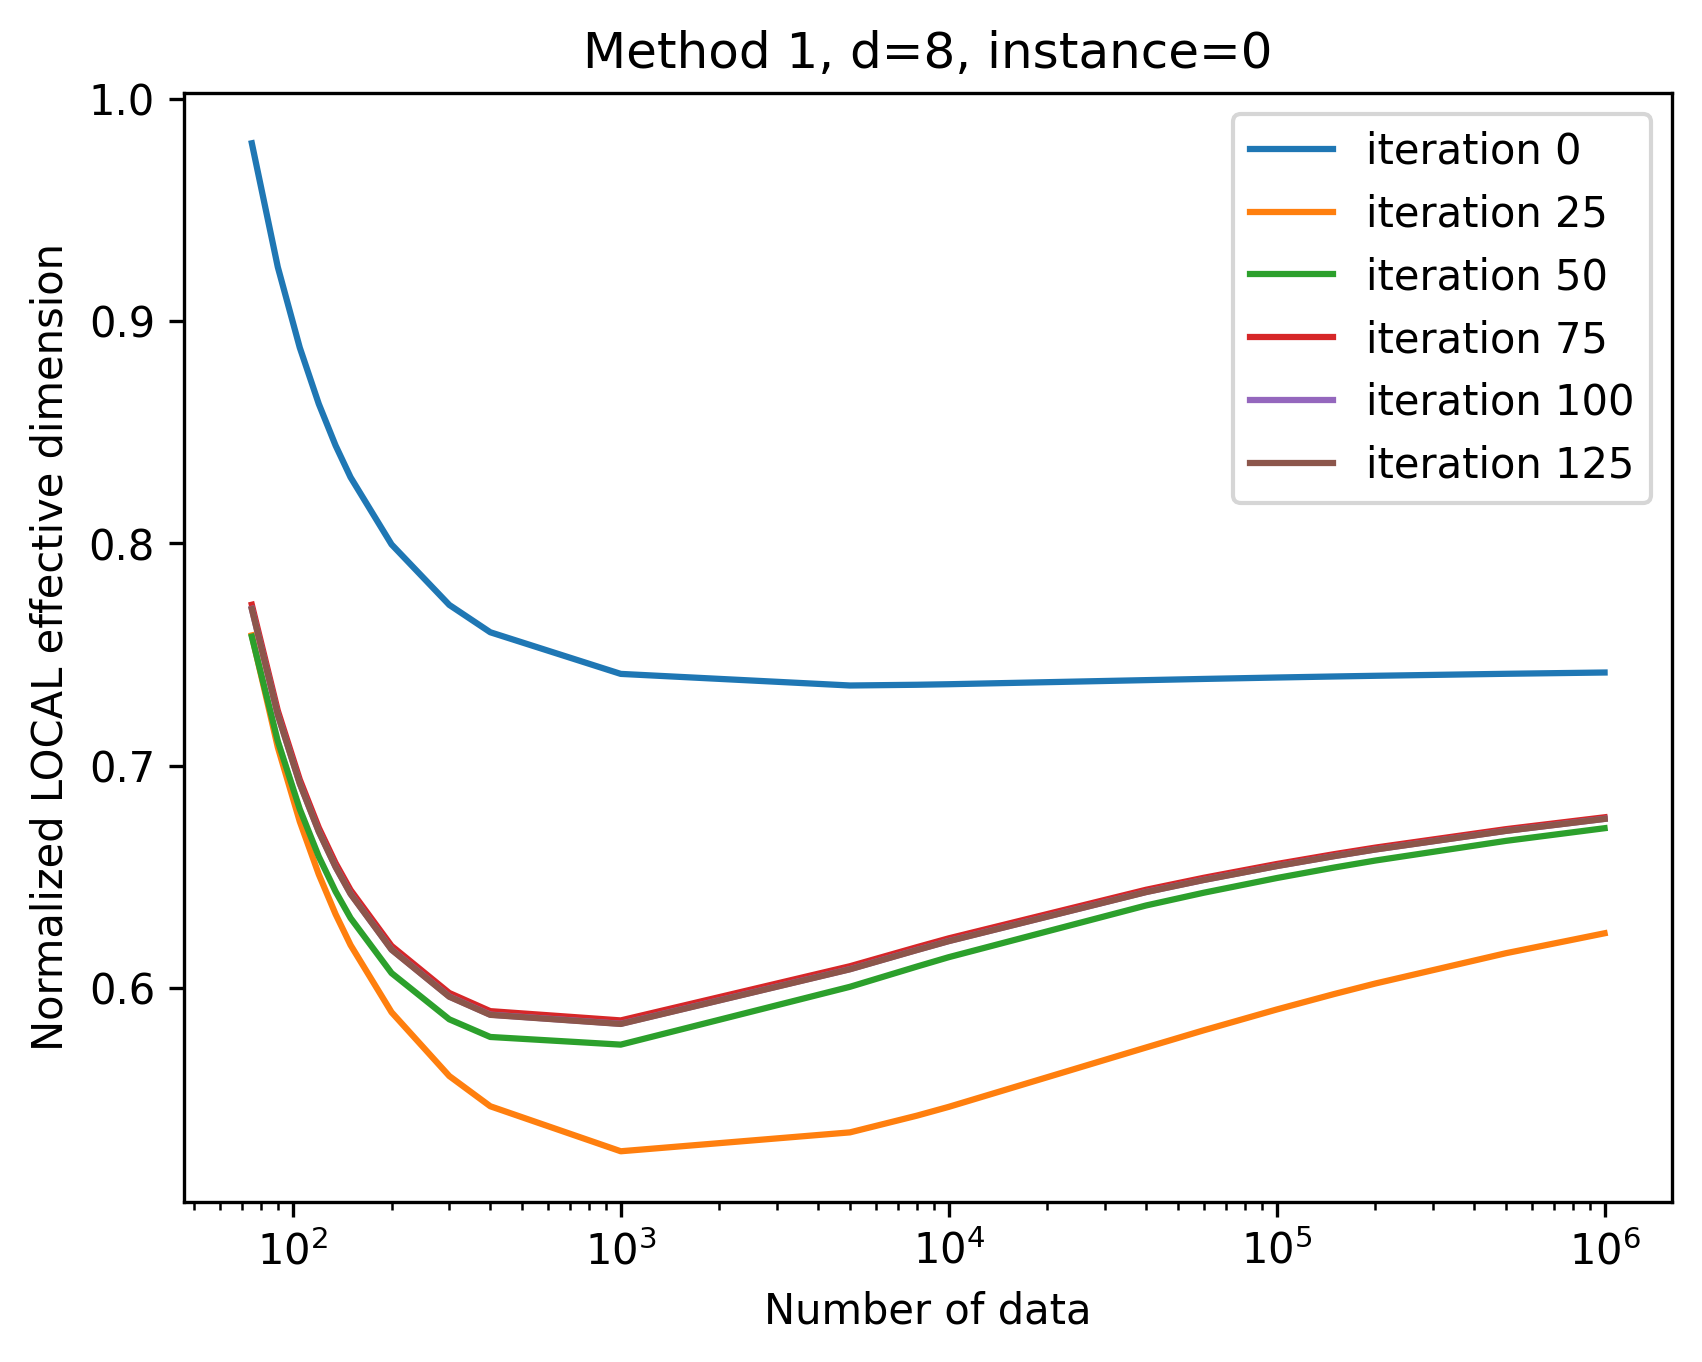

In [8]:
sel_instance = 0
for i in range(len(Local_eff_1[0])):
    plt.plot(n, np.array(Local_eff_1[sel_instance].iloc[i]) / Weights_1.shape[1], label=f"iteration {i*ITER_STEP_SIZE}")

plt.xlabel("Number of data")
plt.ylabel("Normalized LOCAL effective dimension")
plt.title(f'Method 1, d={Weights_1.shape[1]}, instance={sel_instance}')
plt.legend()
plt.plot()
plt.semilogx()

[]

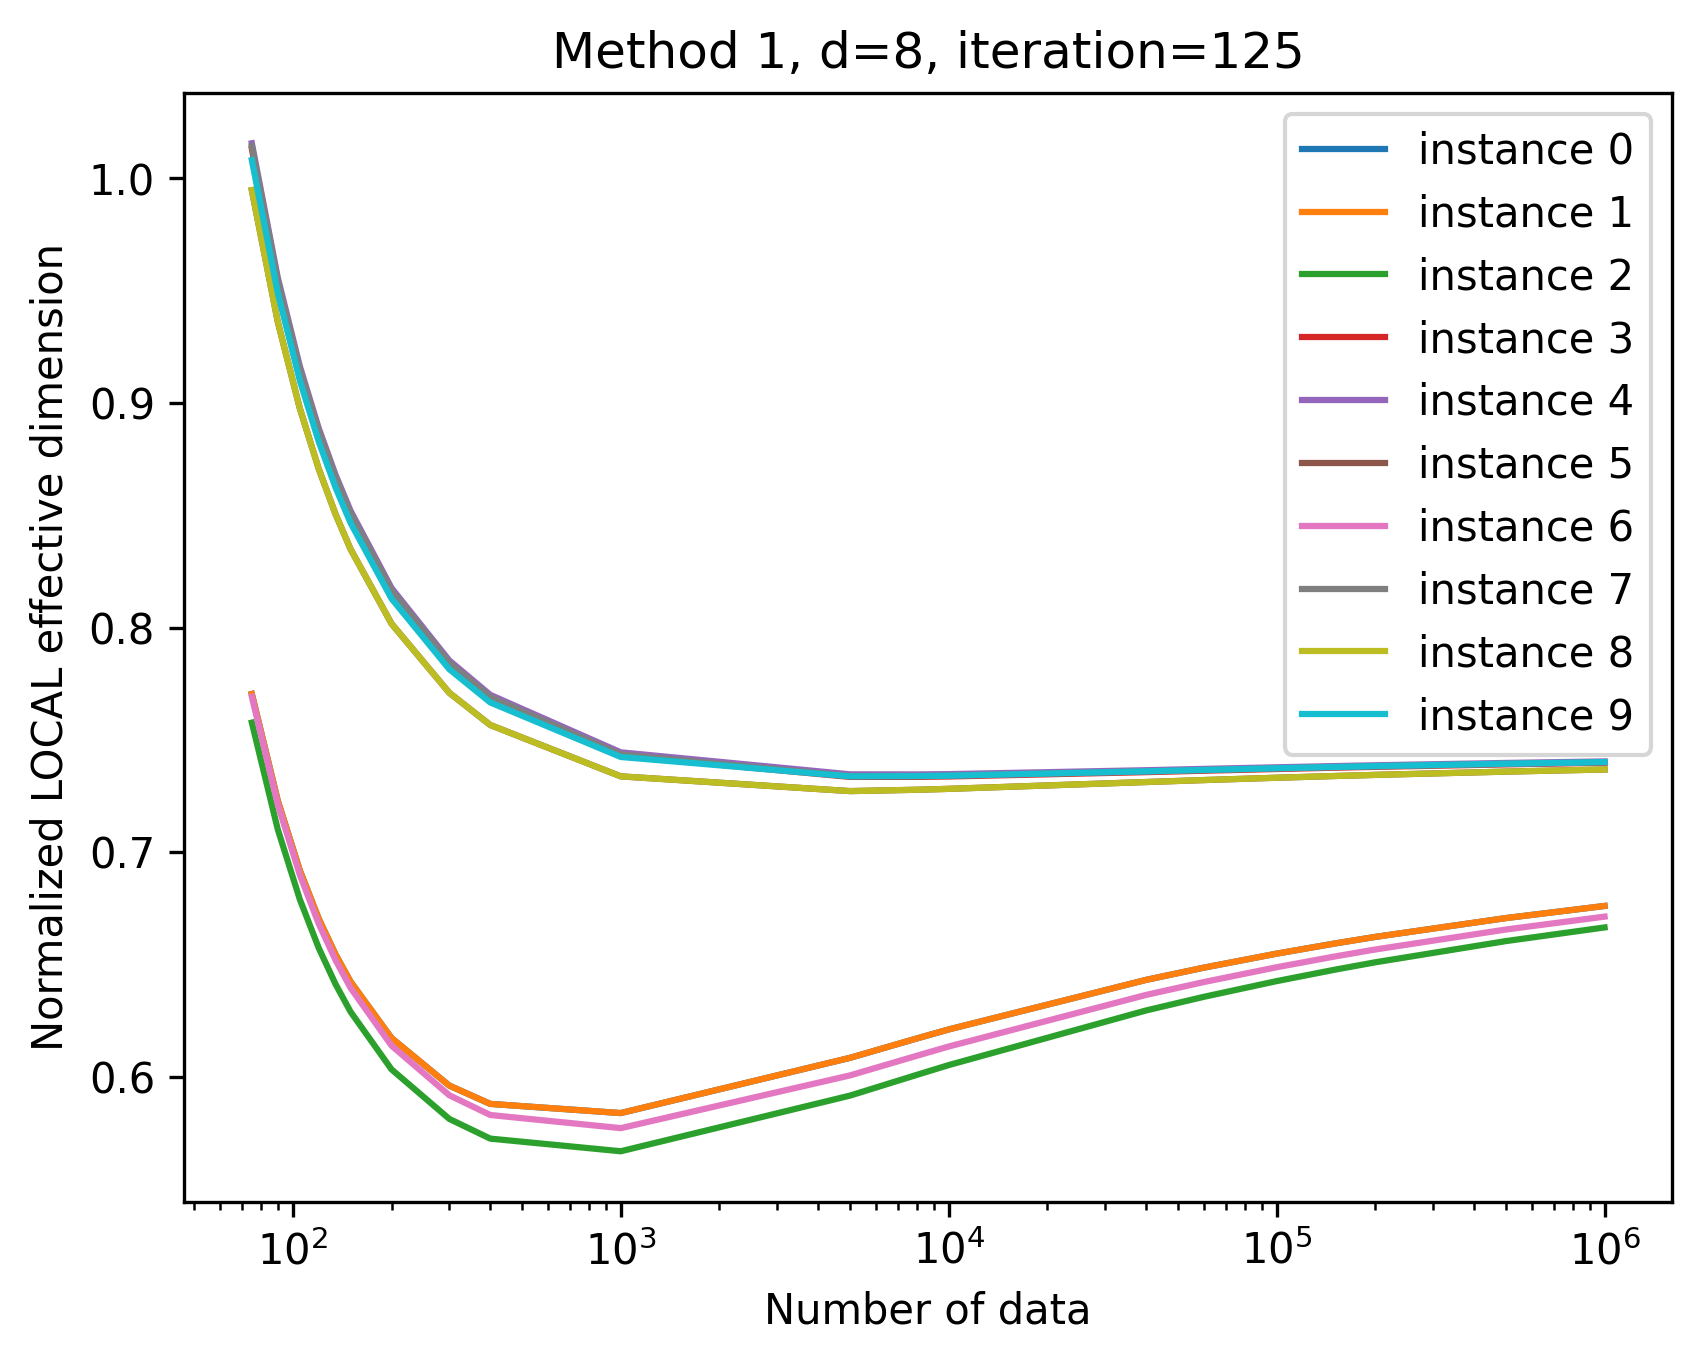

In [9]:
### Plot all method 1 instances at the selected iteration
sel_iter = len(Local_eff_1[0])-1
for i in range(len(Local_eff_1)):
    plt.plot(n, np.array(Local_eff_1[i].iloc[sel_iter]) / Weights_1.shape[1], label=f"instance {i}")

plt.xlabel("Number of data")
plt.ylabel("Normalized LOCAL effective dimension")
plt.title(f'Method 1, d={Weights_1.shape[1]}, iteration={sel_iter*ITER_STEP_SIZE}')
plt.legend()
plt.plot()
plt.semilogx()

[]

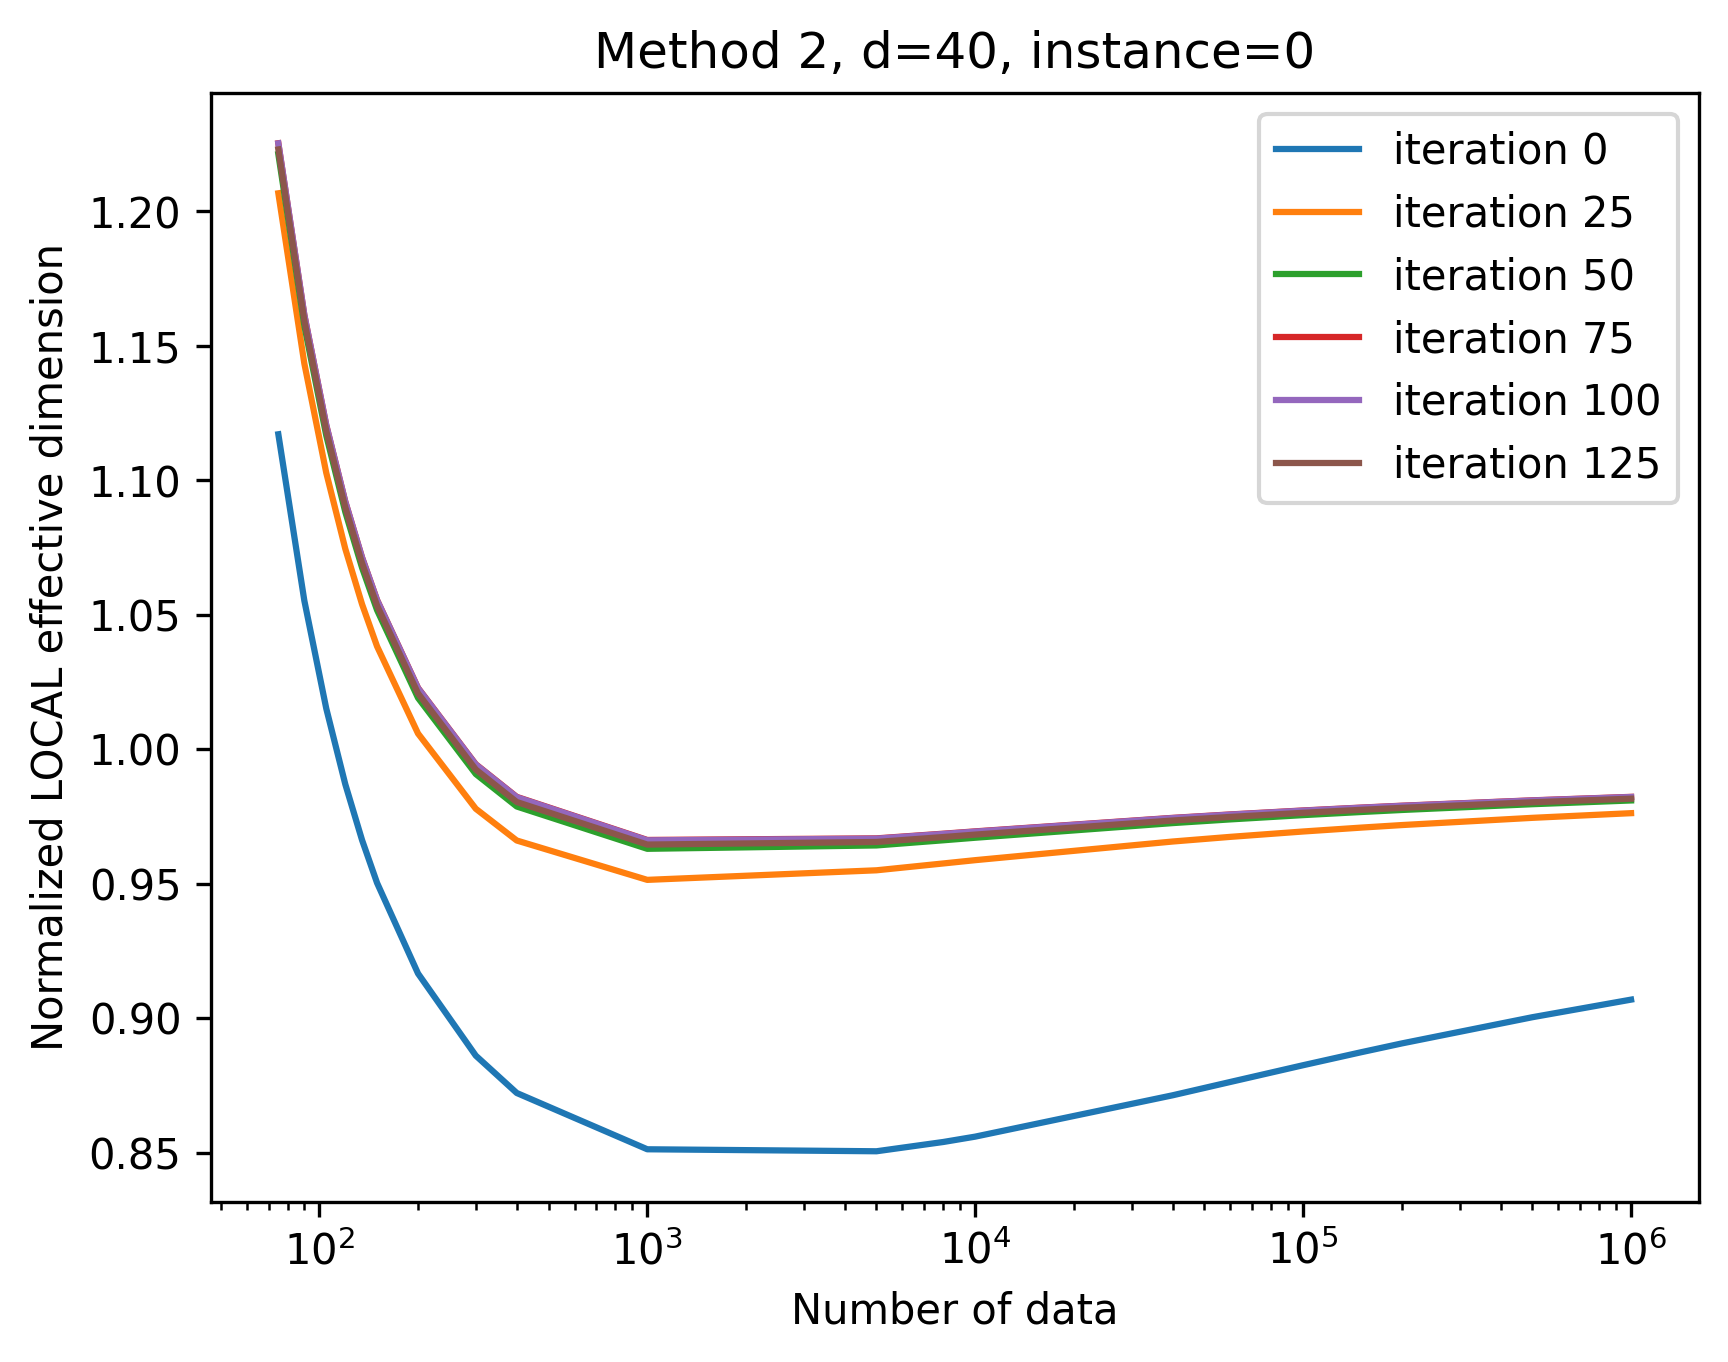

In [10]:
sel_instance = 0
for i in range(len(Local_eff_2[0])):
    plt.plot(n, np.array(Local_eff_2[sel_instance].iloc[i]) / Weights_2.shape[1], label=f"iteration {i*ITER_STEP_SIZE}")

plt.xlabel("Number of data")
plt.ylabel("Normalized LOCAL effective dimension")
plt.title(f'Method 2, d={Weights_2.shape[1]}, instance={sel_instance}')
plt.legend()
plt.plot()
plt.semilogx()

[]

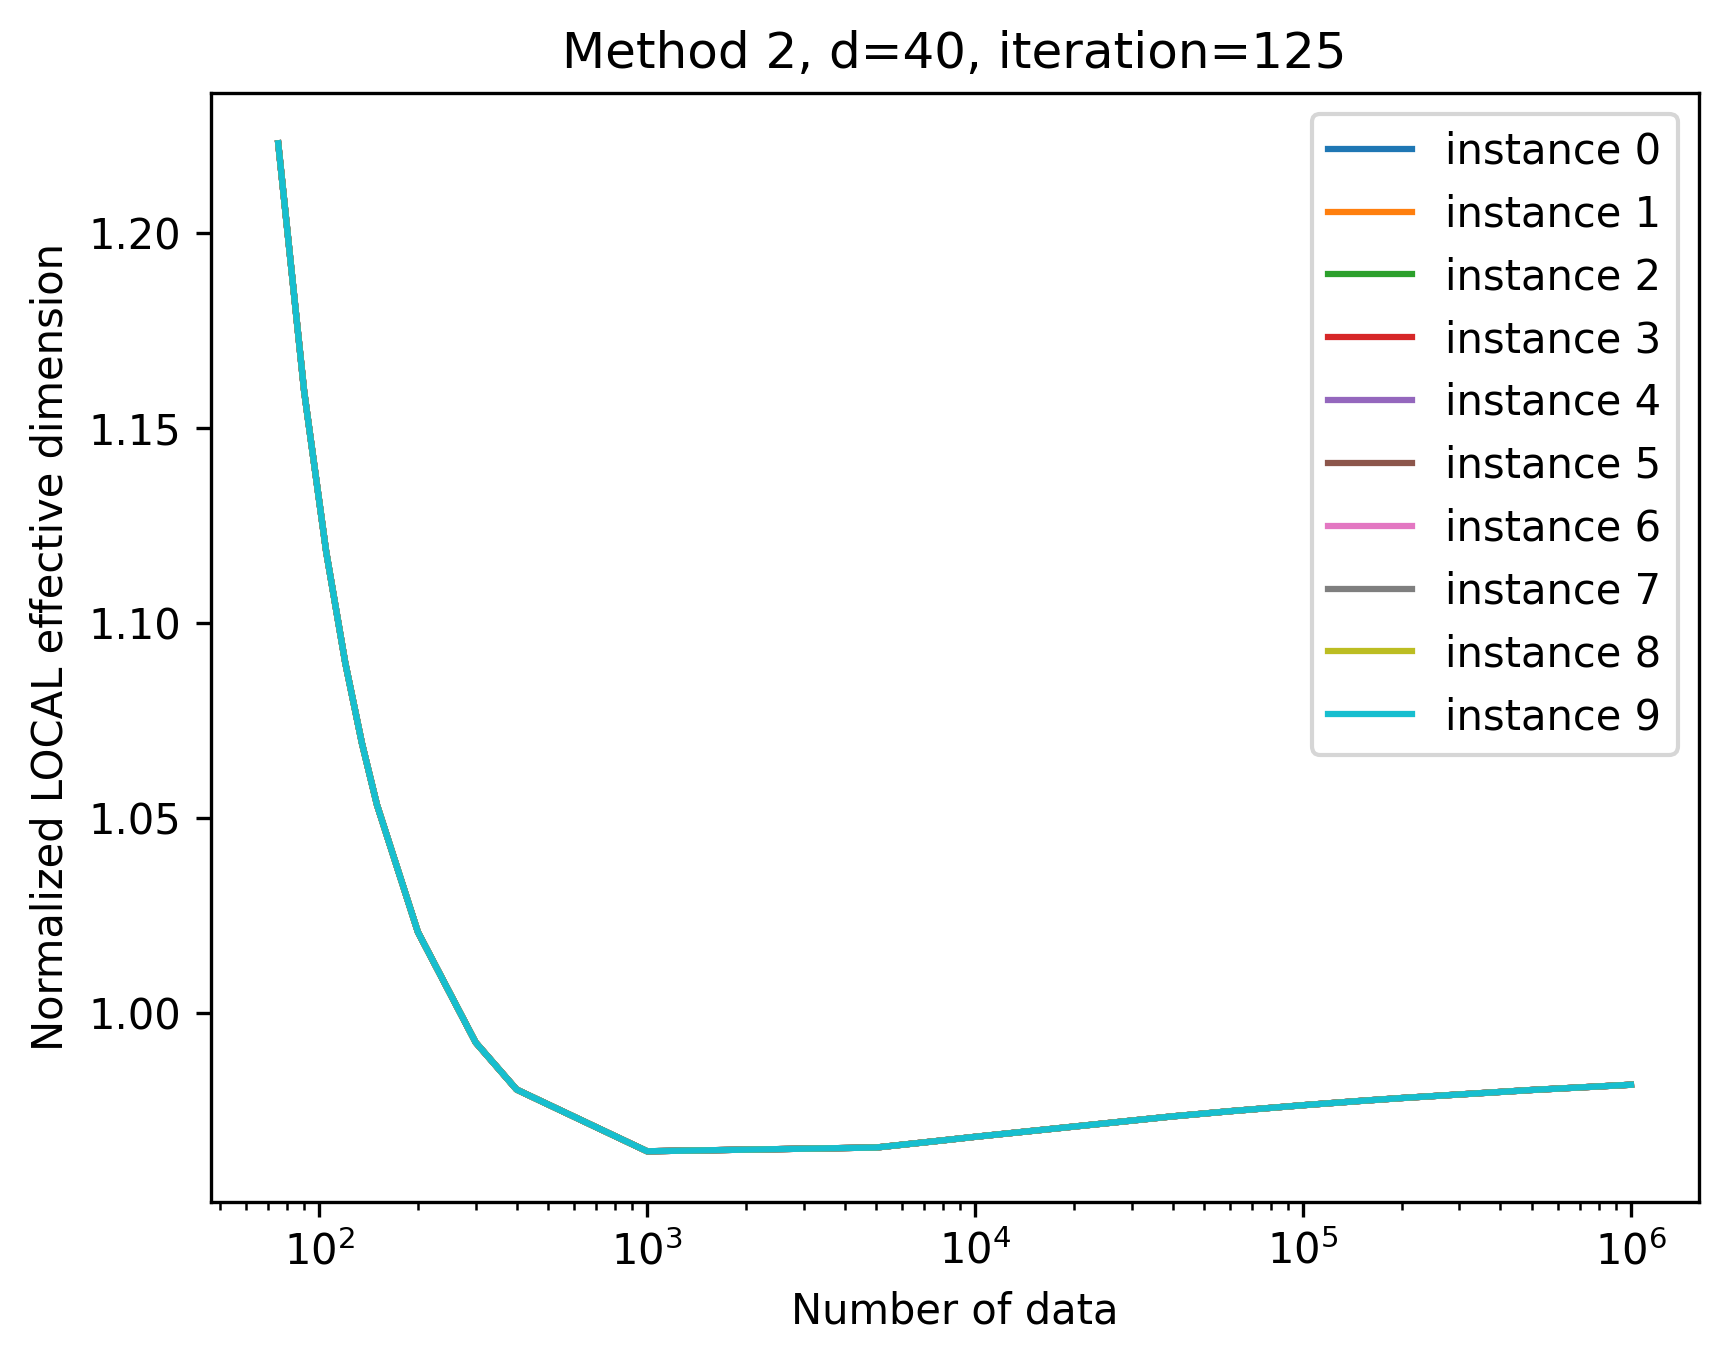

In [11]:
### Plot all method 2 instances at the selected iteration
sel_iter = len(Local_eff_2[0])-1
for i in range(len(Local_eff_2)):
    plt.plot(n, np.array(Local_eff_2[i].iloc[sel_iter]) / Weights_2.shape[1], label=f"instance {i}")

plt.xlabel("Number of data")
plt.ylabel("Normalized LOCAL effective dimension")
plt.title(f'Method 2, d={Weights_2.shape[1]}, iteration={sel_iter*ITER_STEP_SIZE}')
plt.legend()
plt.plot()
plt.semilogx()

[]

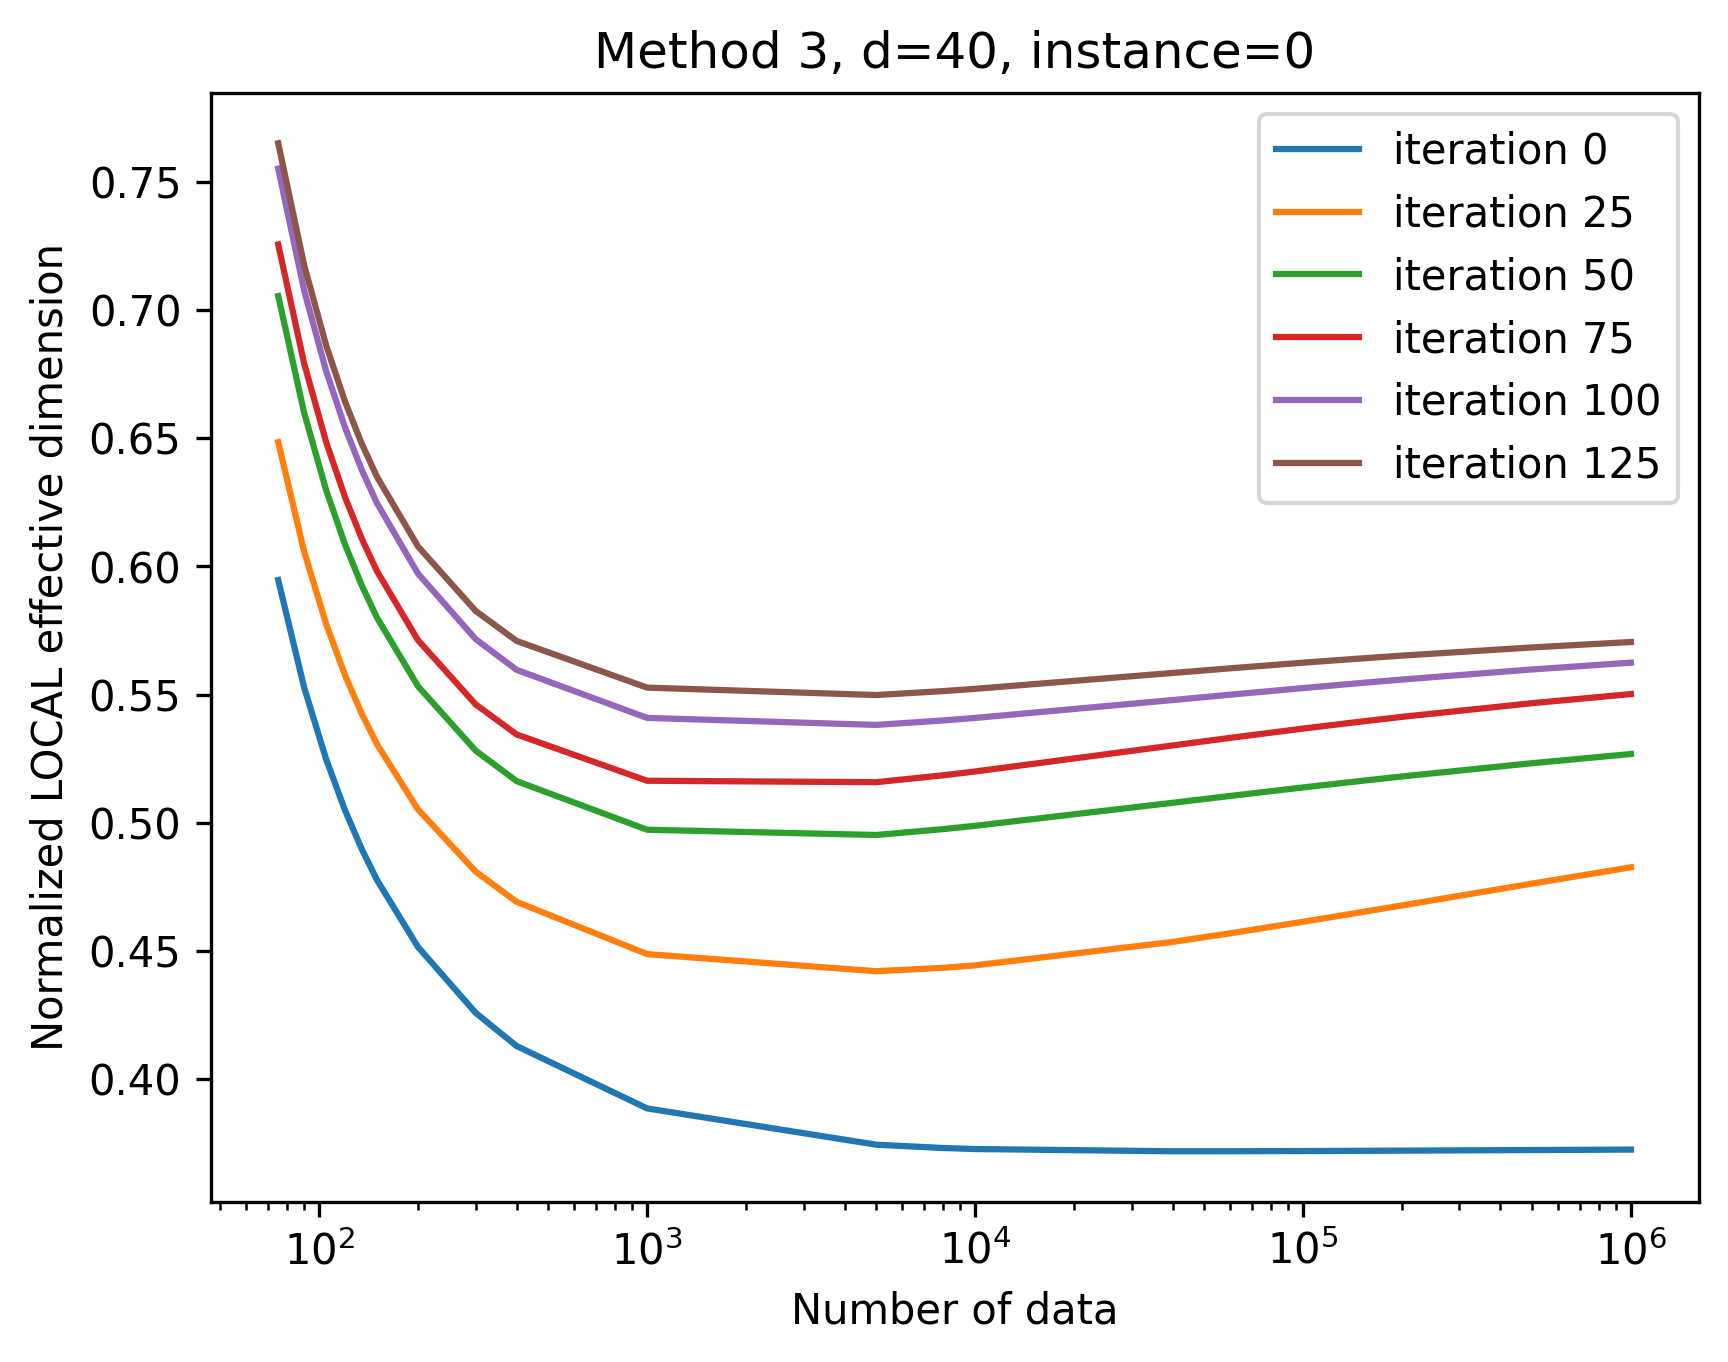

In [12]:
sel_instance = 0
for i in range(len(Local_eff_3[0])):
    plt.plot(n, np.array(Local_eff_3[sel_instance].iloc[i]) / Weights_3.shape[1], label=f"iteration {i*ITER_STEP_SIZE}")

plt.xlabel("Number of data")
plt.ylabel("Normalized LOCAL effective dimension")
plt.title(f'Method 3, d={Weights_3.shape[1]}, instance={sel_instance}')
plt.legend()
plt.plot()
plt.semilogx()

[]

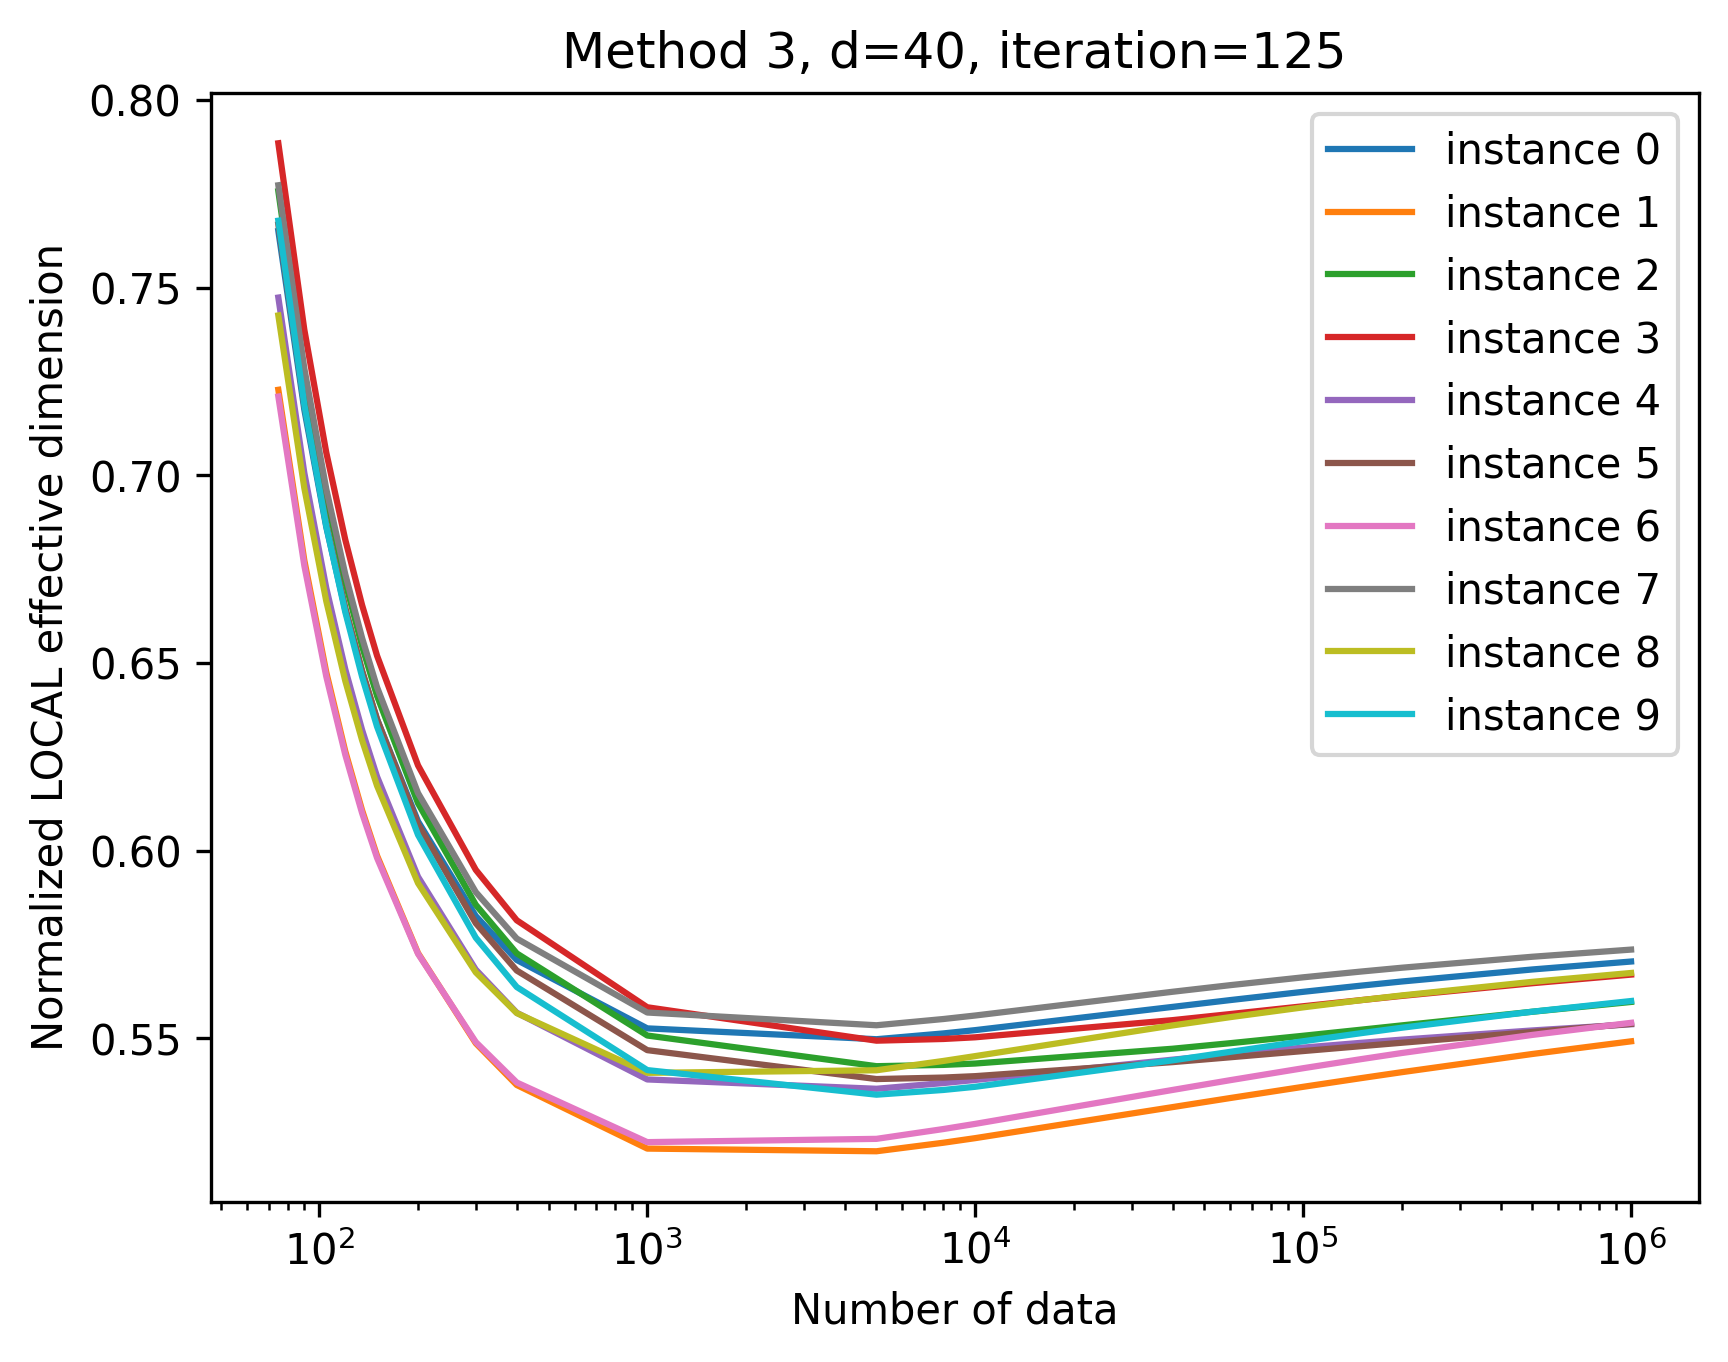

In [13]:
### Plot all method 3 instances at the selected iteration
sel_iter = len(Local_eff_3[0])-1
for i in range(len(Local_eff_3)):
    plt.plot(n, np.array(Local_eff_3[i].iloc[sel_iter]) / Weights_3.shape[1], label=f"instance {i}")

plt.xlabel("Number of data")
plt.ylabel("Normalized LOCAL effective dimension")
plt.title(f'Method 3, d={Weights_3.shape[1]}, iteration={sel_iter*ITER_STEP_SIZE}')
plt.legend()
plt.plot()
plt.semilogx()

# Plot Local Effective Dimension and training results showing variance across instance results

[]

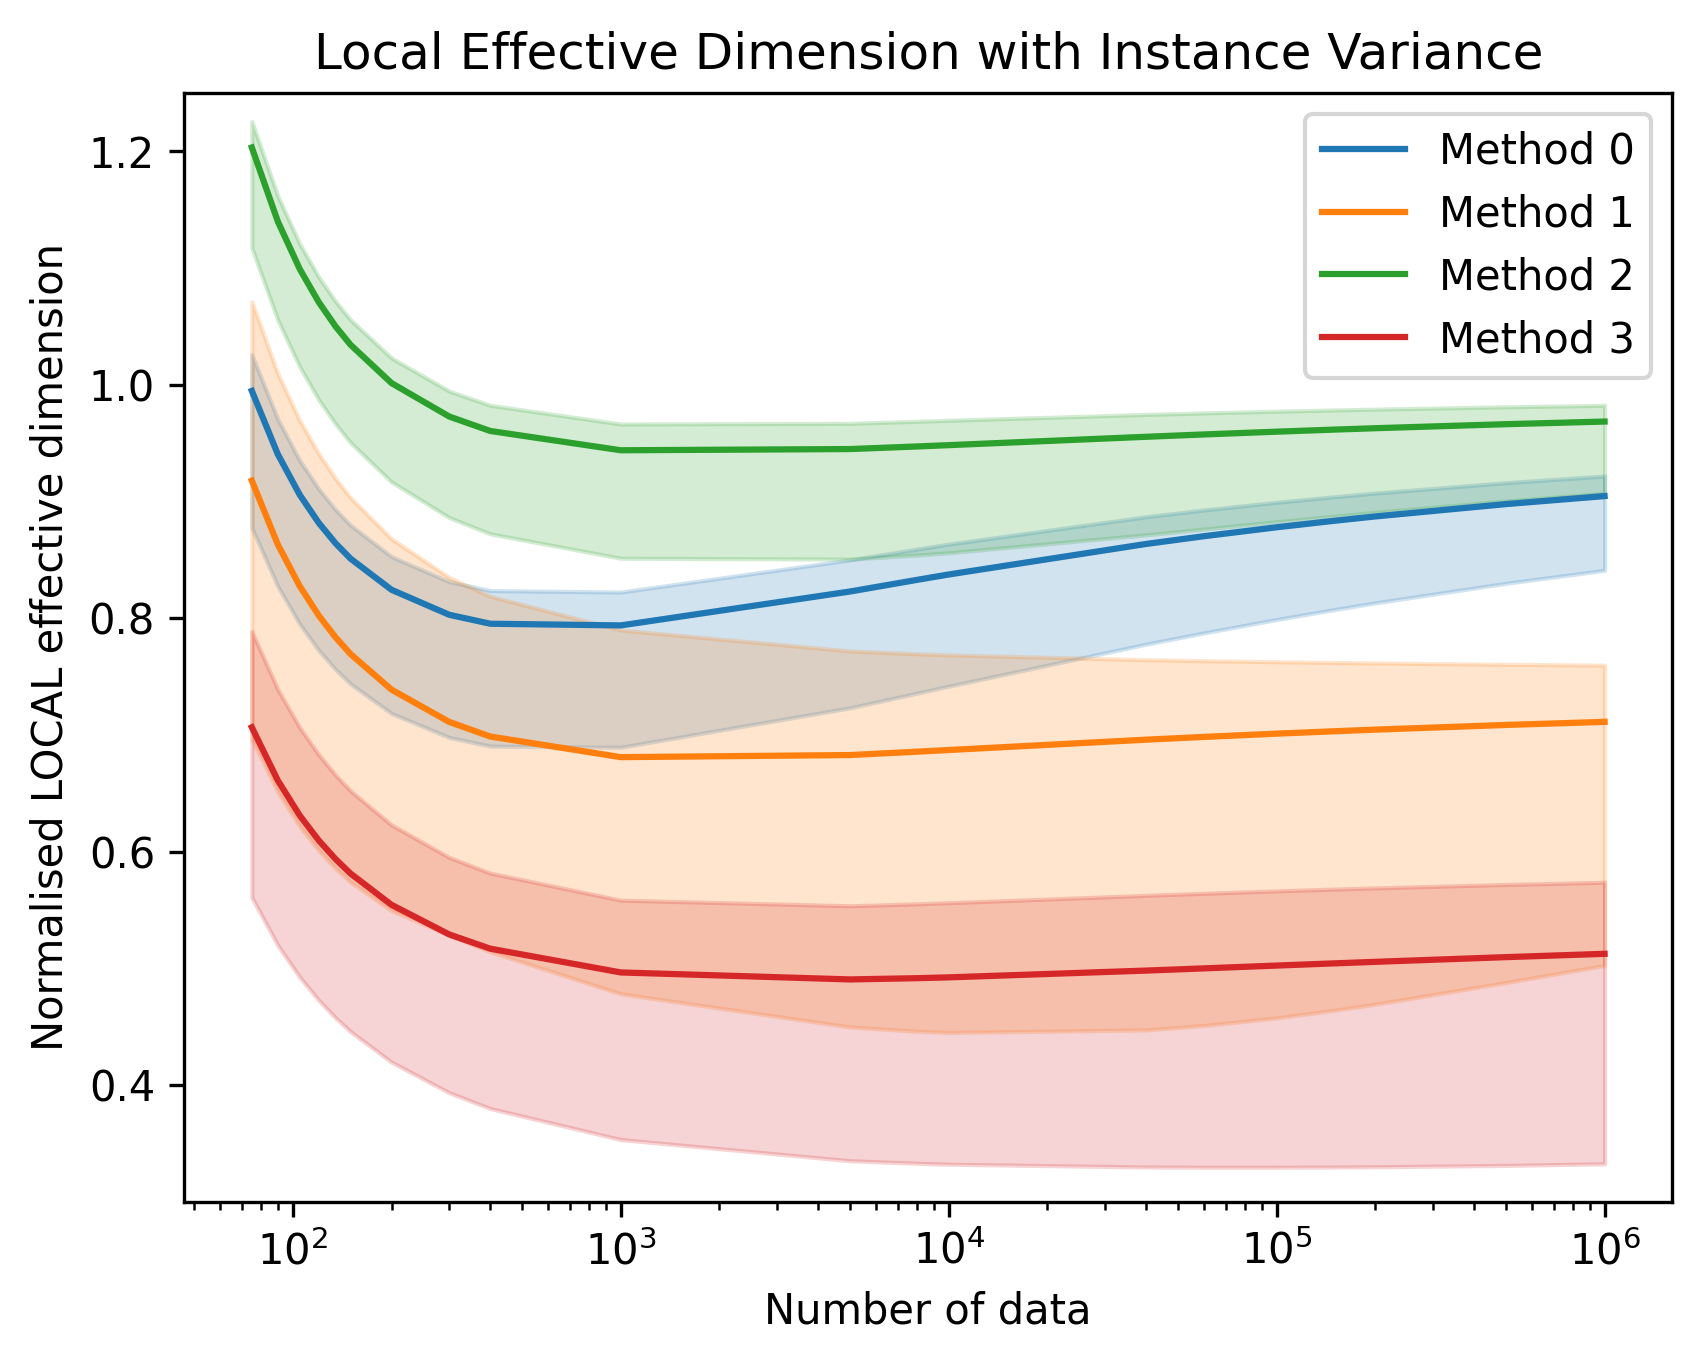

In [14]:
color = ['tab:blue', 'tab:orange' ,'tab:green', 'tab:red']
local_eff_pd = [
    pd.concat(Local_eff_0), 
    pd.concat(Local_eff_1), 
    pd.concat(Local_eff_2),
    pd.concat(Local_eff_3)
]

for c in range(len(local_eff_pd)):
    normal_le = local_eff_pd[c] / d[c]
    max = normal_le.max()
    min = normal_le.min()
    mean = normal_le.mean()

    plt.plot(n, mean, color = color[c], label = f'Method {c}')
    plt.fill_between(n, max, min, color = color[c], alpha = 0.2)

plt.title("Local Effective Dimension with Instance Variance")
plt.ylim(0.3, 1.25)
plt.xlabel("Number of data")
plt.ylabel("Normalised LOCAL effective dimension")
plt.legend(loc = 'best')
plt.plot()
plt.semilogx()

In [15]:
L_before = [
    pd.DataFrame([Local_eff_0[i].iloc[0] for i in range(len(Local_eff_0))]),
    pd.DataFrame([Local_eff_1[i].iloc[0] for i in range(len(Local_eff_1))]),
    pd.DataFrame([Local_eff_2[i].iloc[0] for i in range(len(Local_eff_2))]),
    pd.DataFrame([Local_eff_3[i].iloc[0] for i in range(len(Local_eff_3))])
]

L_after = [
    pd.DataFrame([Local_eff_0[i].iloc[-1] for i in range(len(Local_eff_0))]),
    pd.DataFrame([Local_eff_1[i].iloc[-1] for i in range(len(Local_eff_1))]),
    pd.DataFrame([Local_eff_2[i].iloc[-1] for i in range(len(Local_eff_2))]),
    pd.DataFrame([Local_eff_3[i].iloc[-1] for i in range(len(Local_eff_3))])
]

[]

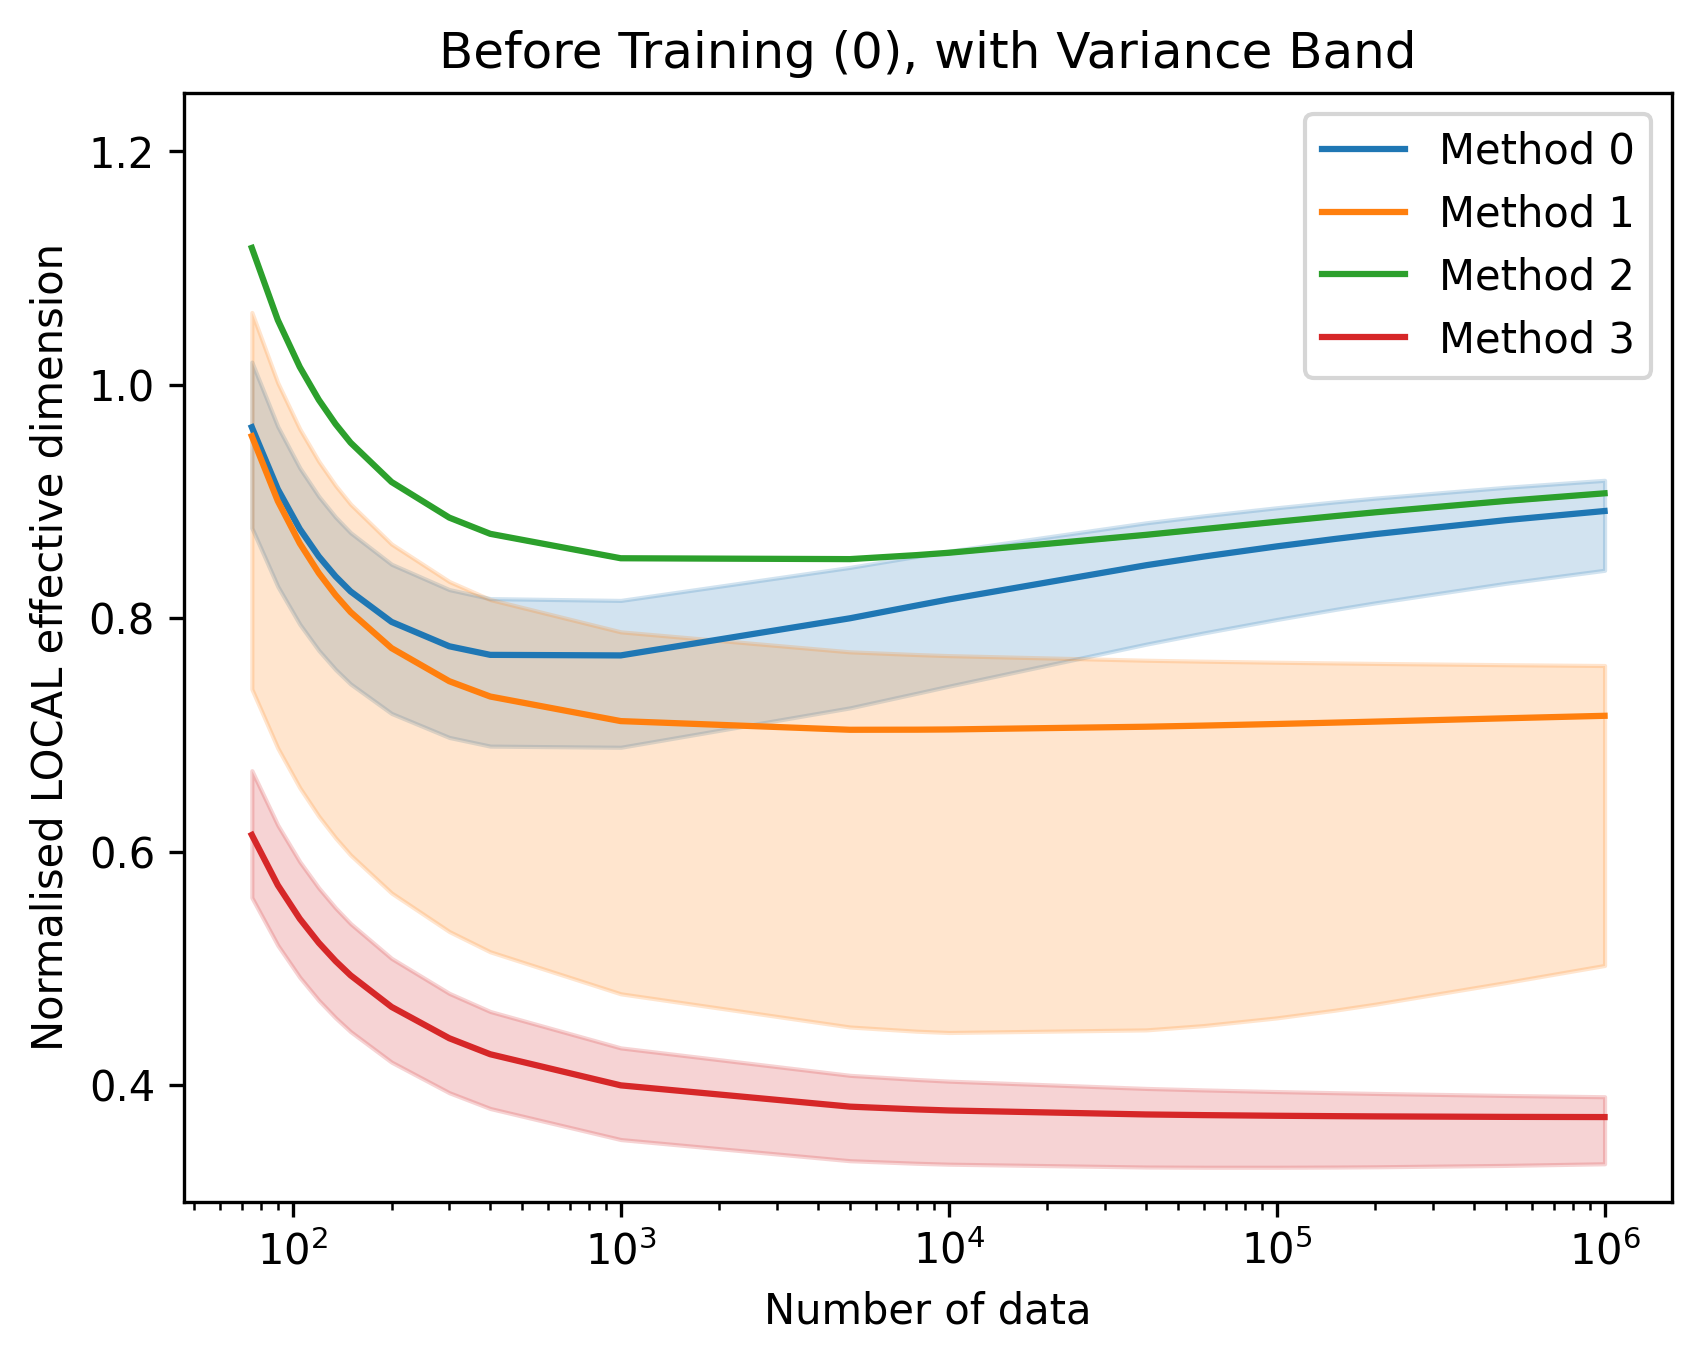

In [16]:
color = ['tab:blue', 'tab:orange' ,'tab:green', 'tab:red']

for c in range(len(L_before)):
    normal_le = L_before[c] / d[c]
    max = normal_le.max()
    min = normal_le.min()
    mean = normal_le.mean()

    plt.plot(n, mean, color = color[c], label = f'Method {c}')
    plt.fill_between(n, max, min, color = color[c], alpha = 0.2)
plt.ylim(0.3, 1.25)
plt.xlabel("Number of data")
plt.ylabel("Normalised LOCAL effective dimension")
plt.legend(loc = 'best')
plt.title('Before Training (0), with Variance Band')
plt.plot()
plt.semilogx()

[]

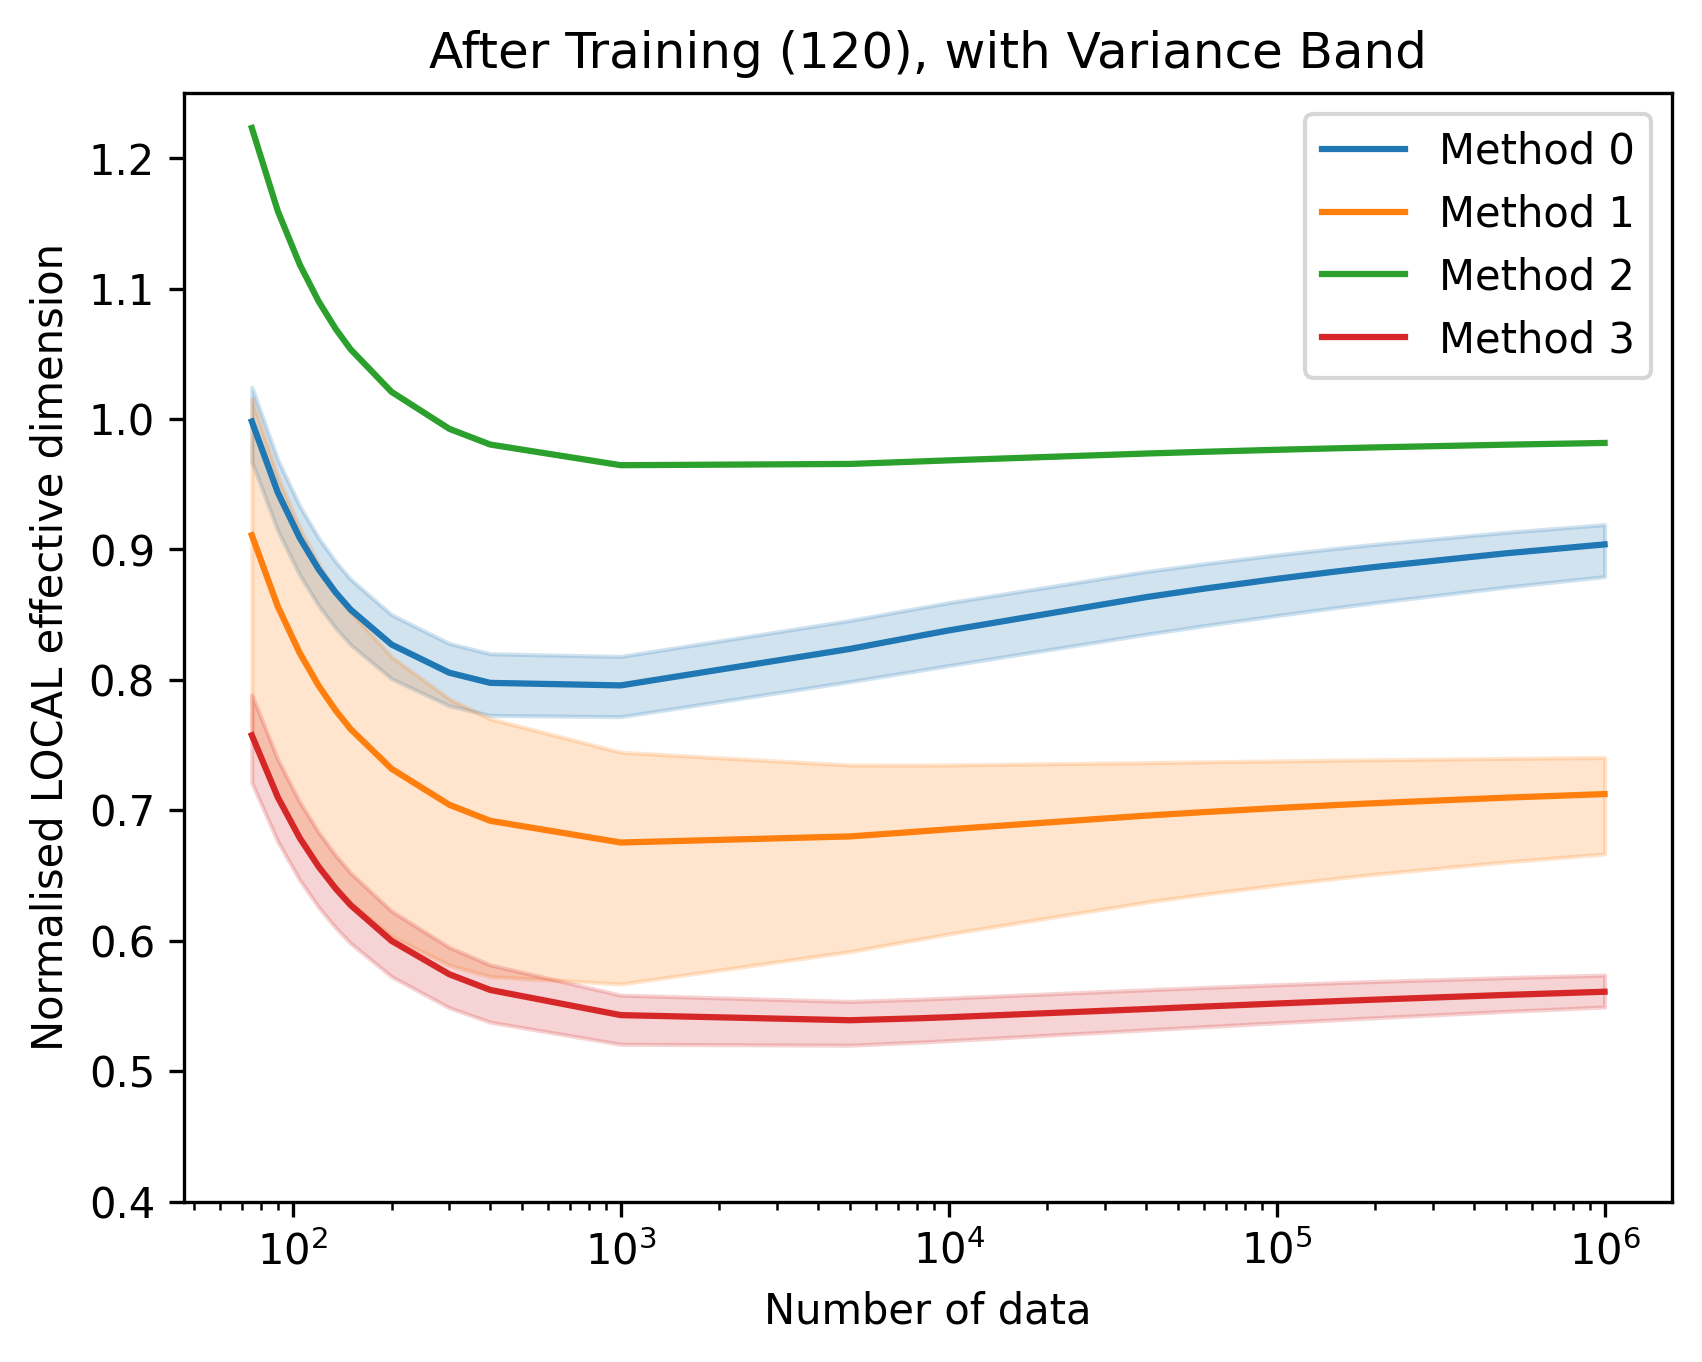

In [17]:
color = ['tab:blue', 'tab:orange' ,'tab:green', 'tab:red']

for c in range(len(L_after)):
    normal_le = L_after[c] / d[c]
    max = normal_le.max()
    min = normal_le.min()
    mean = normal_le.mean()

    plt.plot(n, mean, color = color[c], label = f'Method {c}')
    plt.fill_between(n, max, min, color = color[c], alpha = 0.2)
plt.ylim(0.4, 1.25)
plt.xlabel("Number of data")
plt.ylabel("Normalised LOCAL effective dimension")
plt.legend(loc = 'best')
plt.title('After Training (120), with Variance Band')
plt.plot()
plt.semilogx()

### Sweet spot index
The sweet spot for measuring local affective dimension is calculated for each method as follows:
- First, for each method we calculate the mean of test accuracies at each iteration
- Then, we return an index of the first found highest value
- Finally, the index is normalised to consider the step at each measurements were saved

[]

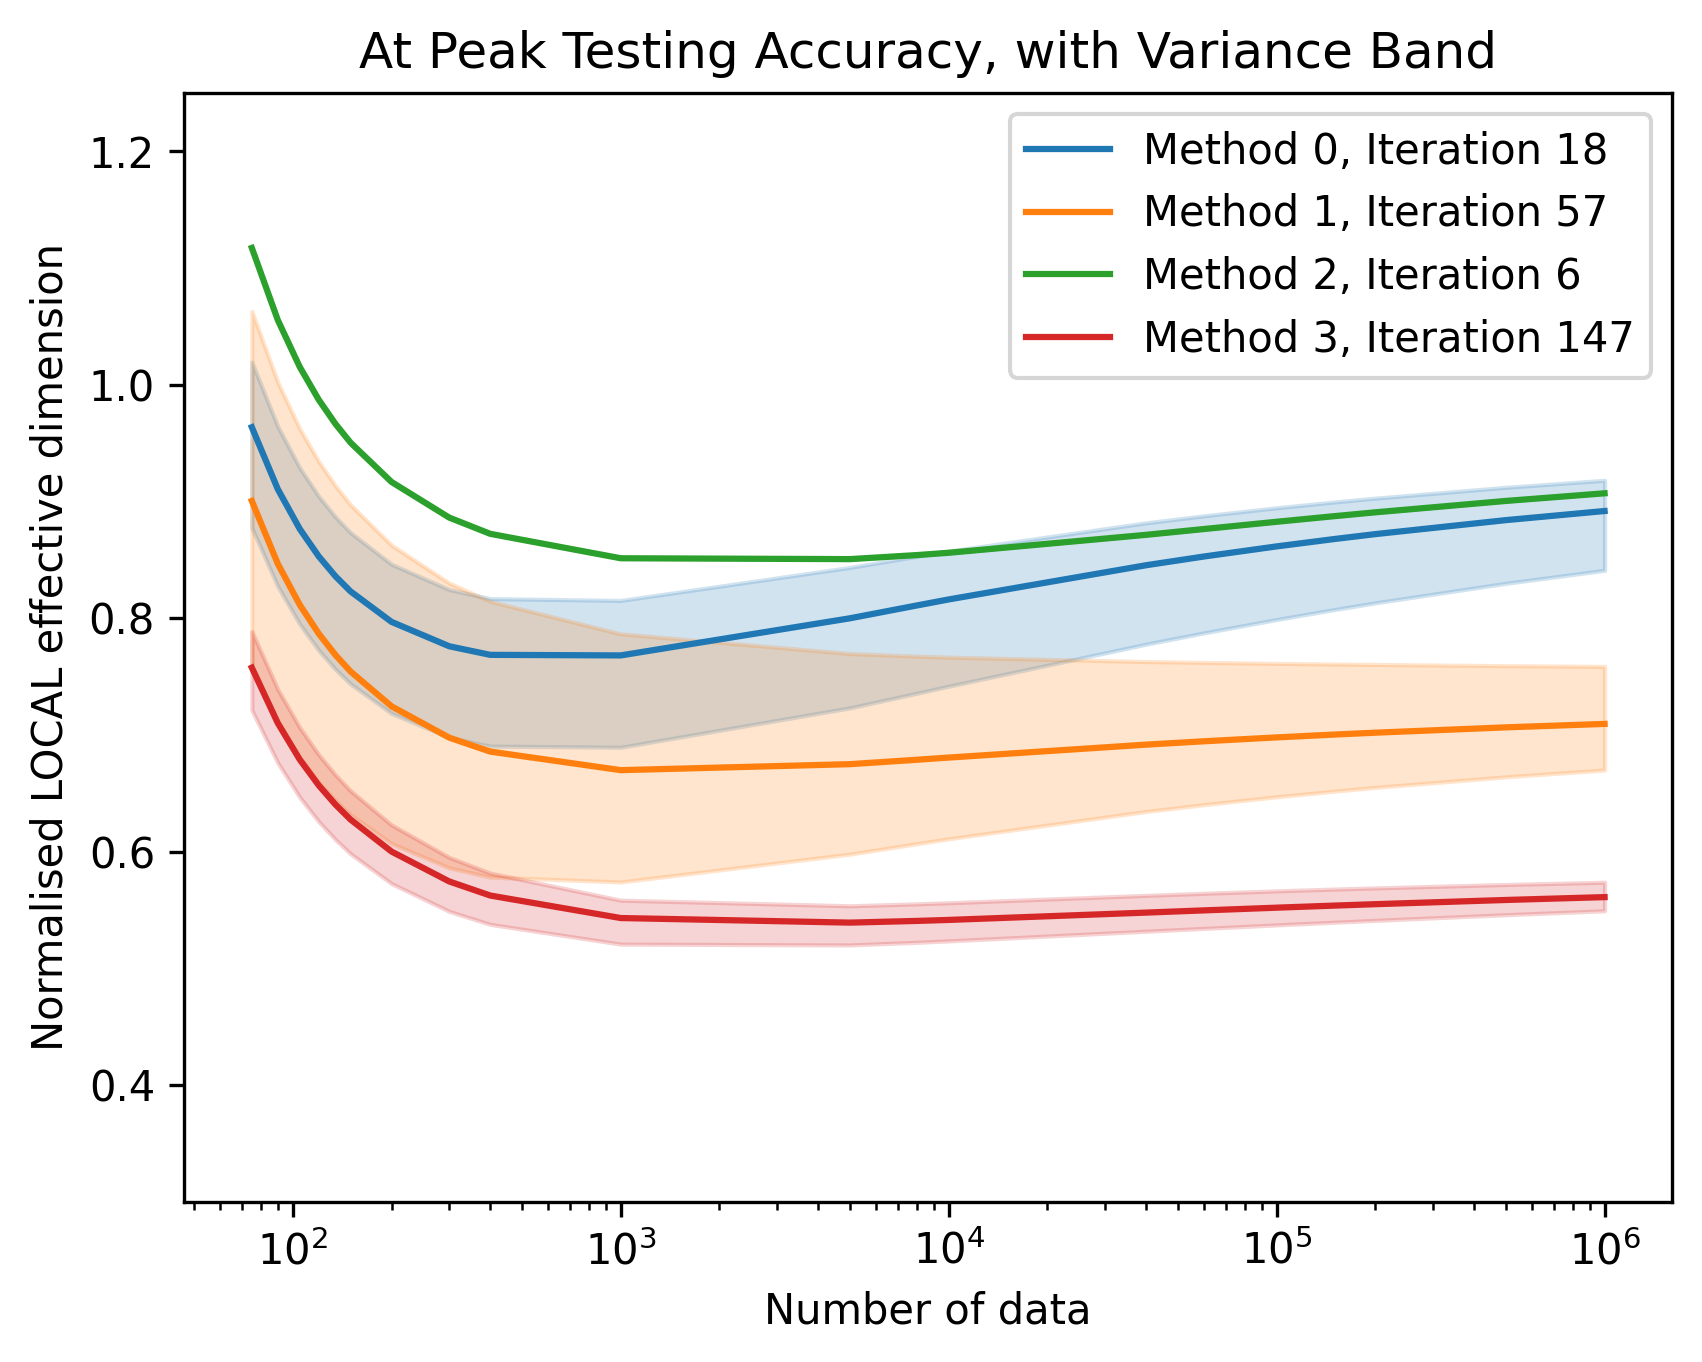

In [18]:
import math

# ITER_STEP_SIZE=25

color = ['tab:blue', 'tab:orange' ,'tab:green', 'tab:red']
sweet_spot_index = [(np.argmax(m)/ITER_STEP_SIZE) for m in [np.mean(l, axis=0) for l in test_scores]]
sweet_spot_index_floor = [math.floor(np.argmax(m)/ITER_STEP_SIZE) for m in [np.mean(l, axis=0) for l in test_scores]]

# <- I got the sweet spot based on the Train score vs. iteration graph
L_sweet_spot = [
    pd.DataFrame([Local_eff_0[i].iloc[sweet_spot_index_floor[0]] for i in range(len(Local_eff_0))]),
    pd.DataFrame([Local_eff_1[i].iloc[sweet_spot_index_floor[1]] for i in range(len(Local_eff_1))]),
    pd.DataFrame([Local_eff_2[i].iloc[sweet_spot_index_floor[2]] for i in range(len(Local_eff_2))]),
    pd.DataFrame([Local_eff_3[i].iloc[sweet_spot_index_floor[3]] for i in range(len(Local_eff_3))])
]

for c in range(len(L_sweet_spot)):
    normal_le = L_sweet_spot[c] / d[c]
    max = normal_le.max()
    min = normal_le.min()
    mean = normal_le.mean()

    plt.plot(n, mean, color = color[c], label = f'Method {c}, Iteration {round(sweet_spot_index[c]*ITER_STEP_SIZE)}')
    plt.fill_between(n, max, min, color = color[c], alpha = 0.2)

plt.ylim(0.3, 1.25)
plt.xlabel("Number of data")
plt.ylabel("Normalised LOCAL effective dimension")
plt.legend(loc = 'best')
plt.title('At Peak Testing Accuracy, with Variance Band')
plt.plot()
plt.semilogx()

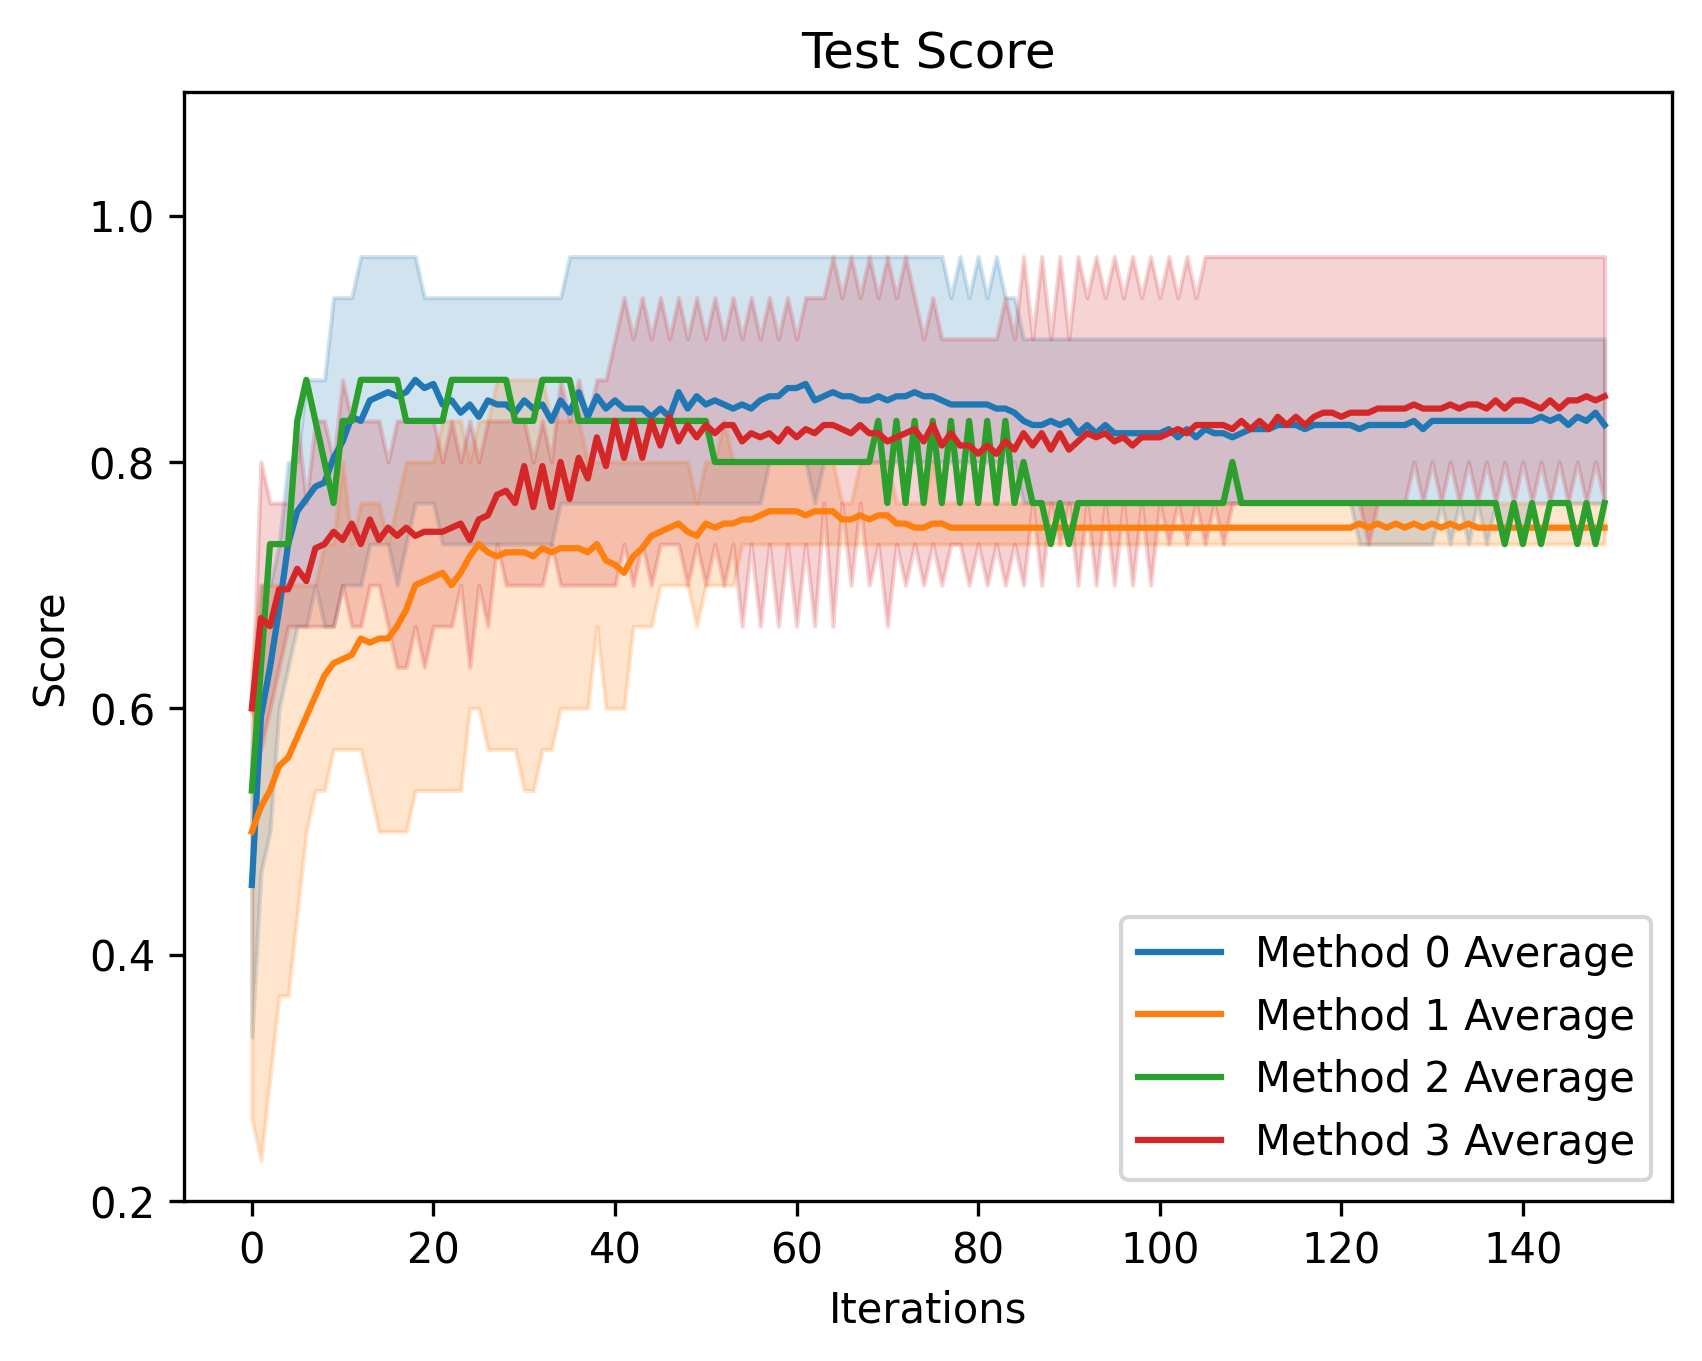

In [19]:
plot_score_range(test_scores, smooth_weight=0, title='Test Score')

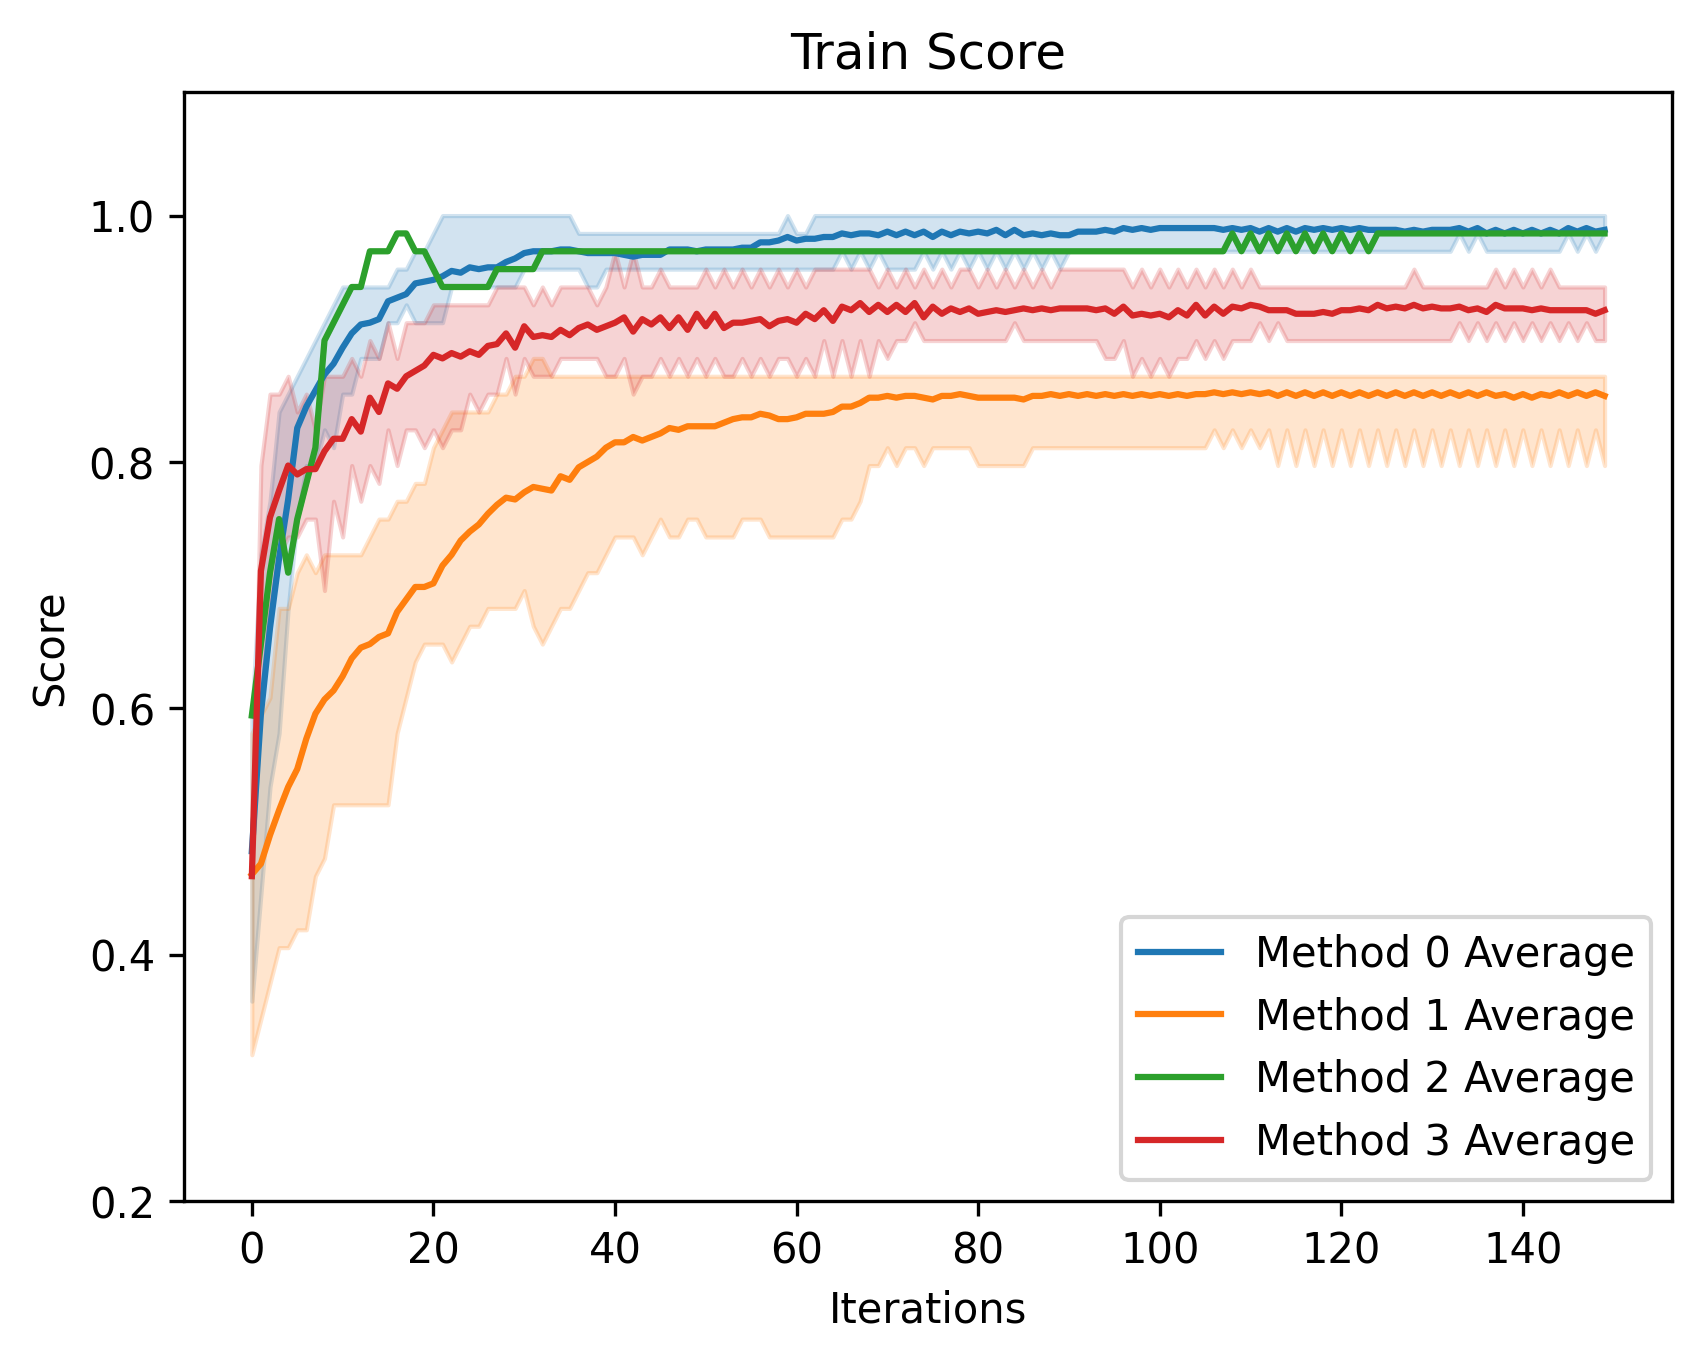

In [20]:
plot_score_range(train_score, smooth_weight=0, title='Train Score')

# Global Effective Dimension

[]

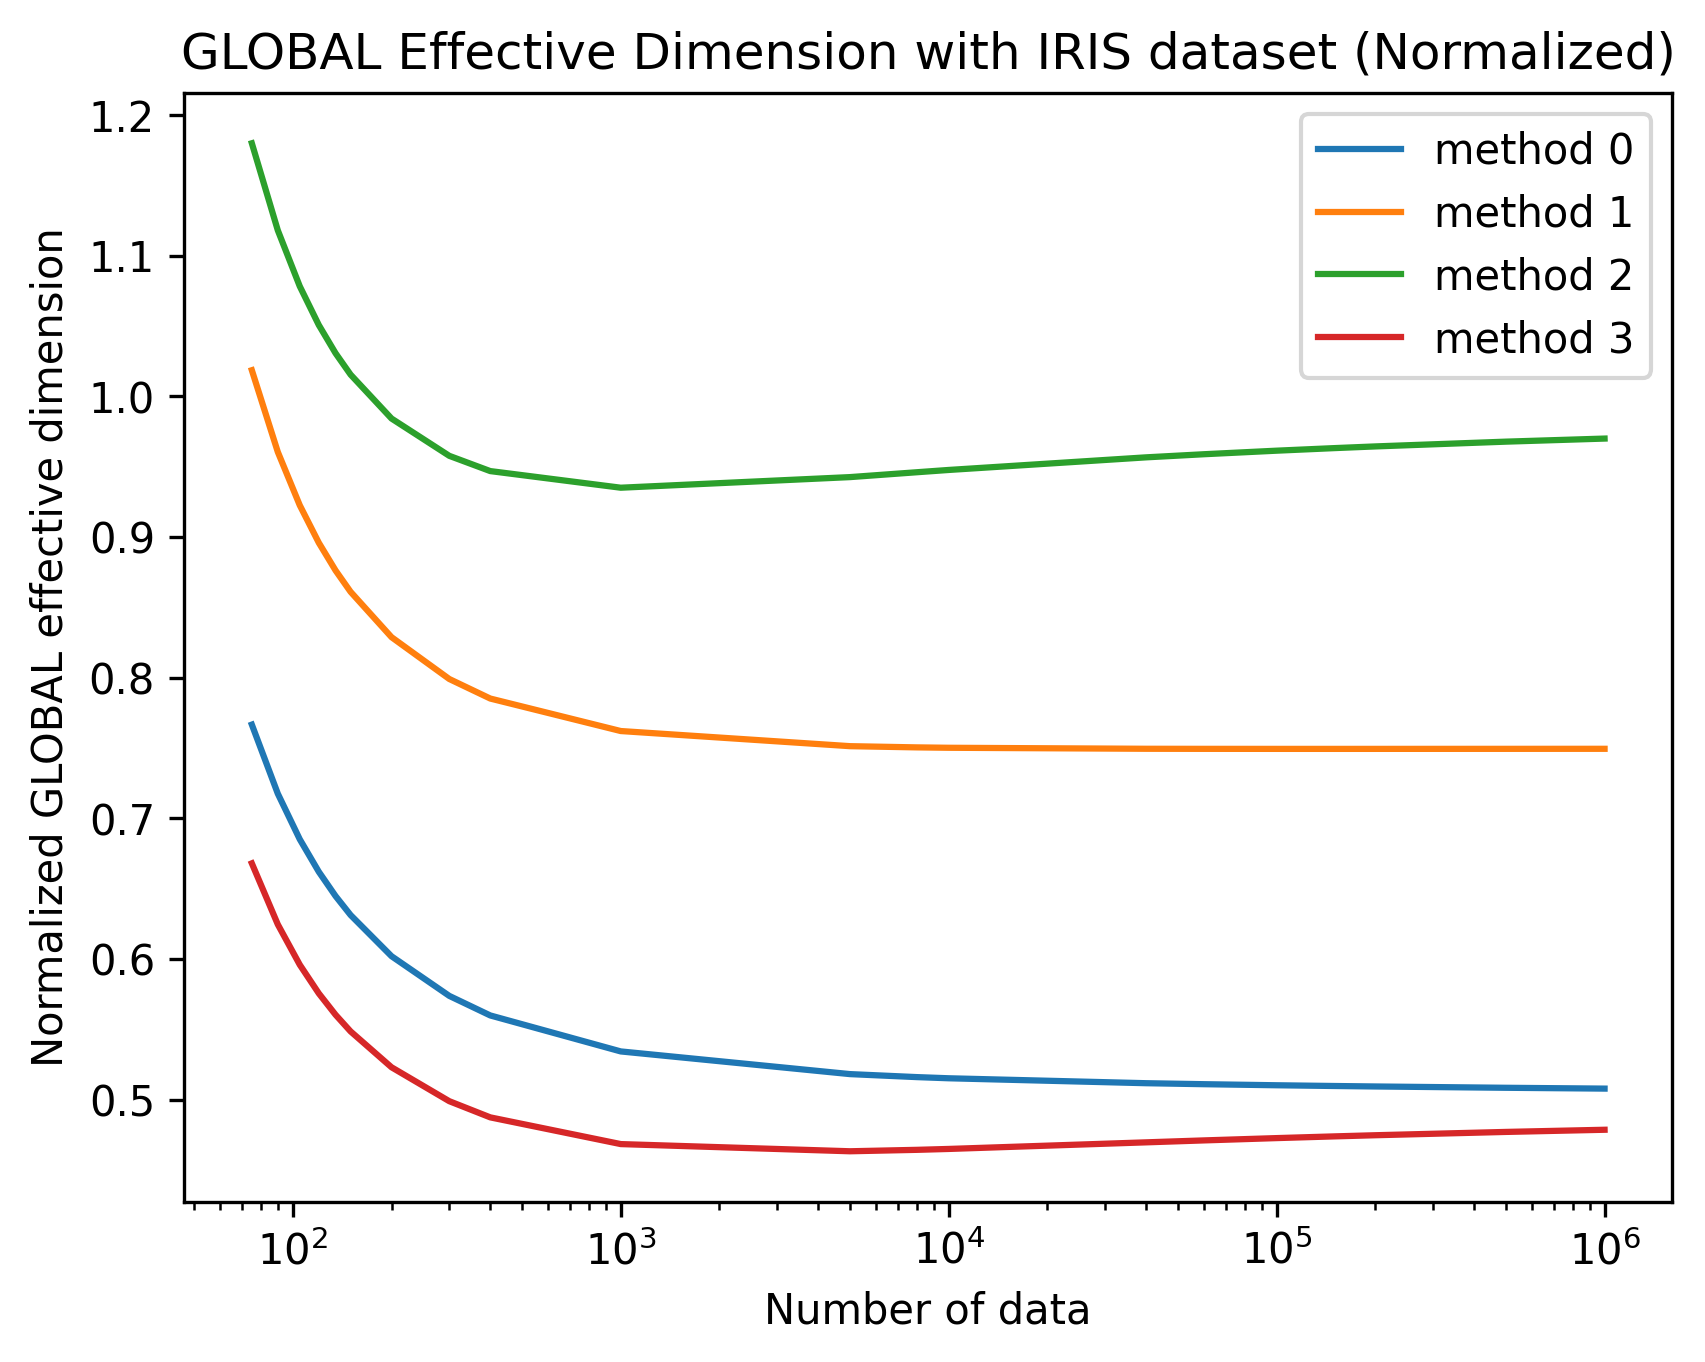

In [21]:
plt.title('GLOBAL Effective Dimension with IRIS dataset (Normalized)')
plt.plot(n, np.array(Global_eff_0) / Weights_0.shape[1], label = 'method 0')
plt.plot(n, np.array(Global_eff_1) / Weights_1.shape[1], label = 'method 1')
plt.plot(n, np.array(Global_eff_2) / Weights_2.shape[1], label = 'method 2')
plt.plot(n, np.array(Global_eff_3) / Weights_3.shape[1], label = 'method 3')
plt.xlabel("Number of data")
plt.ylabel("Normalized GLOBAL effective dimension")
plt.legend(loc='best')
plt.plot()
plt.semilogx()

In [22]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.23.1', 'qiskit-aer': '0.11.2', 'qiskit-ignis': None, 'qiskit-ibmq-provider': '0.20.0', 'qiskit': '0.41.0', 'qiskit-nature': '0.5.2', 'qiskit-finance': '0.3.4', 'qiskit-optimization': '0.5.0', 'qiskit-machine-learning': '0.5.0'}